In [69]:
# GPT가 준 코드 검토하면서 진행
# 모델 : 규칙 기반 최적화(스왑)
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance, beta, norm
import matplotlib.pyplot as plt

np.random.seed(42)

# 1) [0, 100] 범위의 비정규 혼합 분포 생성
def make_mixture_0_100(n=200, seed=42, mix_ratio=0.65):
    rng = np.random.default_rng(seed)
    n1 = int(n * mix_ratio)
    n2 = n - n1
    comp1 = beta(a=2.0, b=5.0).rvs(size=n1, random_state=seed) * 100.0
    comp2 = np.clip(norm(loc=70.0, scale=8.0).rvs(size=n2, random_state=seed+1), 0.0, 100.0)
    X = np.concatenate([comp1, comp2])
    rng.shuffle(X)
    return X
# 실행
x = make_mixture_0_100(n=200, seed=42)

In [70]:
x

array([87.84287719, 36.78240872, 40.8646985 , 15.25833147, 16.22660261,
       17.72703795,  6.75359075, 78.11990813, 61.62528811, 17.9247513 ,
       26.34084881, 59.60670925, 15.45074012, 20.33138813, 73.94328678,
       64.44181885, 70.04164548, 65.22422664, 80.10289236, 36.62241585,
       53.86521682, 72.4634481 , 74.44485587, 72.0591994 , 77.6693875 ,
       66.80707425, 18.38768761, 70.88701184, 65.05245876, 66.90673492,
        6.85869246, 33.70138955, 24.09358088, 29.83728427, 37.62367882,
       26.73316735, 70.1123243 , 65.72067521, 64.75284683, 38.55671372,
       64.98812761,  4.43858001, 15.99675758, 28.35202998, 88.13034167,
       80.14732049, 47.59204965, 19.82904719, 46.13858275, 10.77670455,
       32.65987258, 20.89847739, 18.41289217, 20.20967665, 26.2850399 ,
       76.86458677, 67.69247854, 32.57956107, 41.59590873, 21.93544912,
       30.96377074, 55.02830781, 63.10331604, 12.71314766, 13.17706241,
       17.18540725,  9.83214608, 16.9995874 , 22.37663665, 18.63

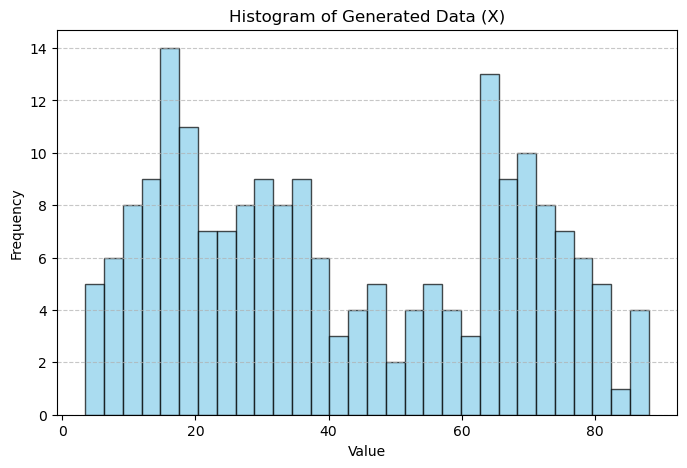

In [71]:
import matplotlib.pyplot as plt

# 히스토그램 시각화
plt.figure(figsize=(8, 5))
plt.hist(x, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Generated Data (X)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [96]:
# 손실함수: ∑ W1(그룹, 모집단) + 균형 패널티
def compute_loss(x, groups, k=2, lam=5.0): # x : 원본 데이터, groups : 그룹 배정 정보, k : 그룹 수, lam : 균형 패널티 계수
    loss = 0.0 # 전체 손실값 초기화
    n = len(x) # 데이터 수
    for g_n in range(k): # 0,1
        group_k = x[groups == g_n] # [groups == g_n] : groups 배열에서 g_n인 인덱스의 불리언 배열 마스크 반환
        if len(group_k) == 0:
            return 1e12
        loss += wasserstein_distance(group_k, x) # group_k와 원본 데이터 x 간의 확률분포 차이 계산 -> for문 돌면서 각 그룹에 대해 누적
    size_penalty = 0.0 # 균형 패널티 초기화
    for g_n in range(k):
        size_ratio = np.sum(groups == g_n)/k # 모집단에서 해당 그룹의 비율
        ideal_ratio = 1.0/k # 이상적인 그룹 비율
        size_penalty += abs(size_ratio - ideal_ratio) # 그룹 크기 차이의 절대값 누적
    return loss + lam * size_penalty

# 초기화
def init_alternate_split(x, k=2):
    order = np.argsort(x) # 오름차순 정렬 했을 때의 순서에서 원래 인덱스 반환
    groups = np.empty(len(x), dtype=int) # 길이가 len(x)인 빈 배열 생성
    for order_idx, order_value in enumerate(order): # order_idx : order의 인덱스(그룹 배정용), order_value : order의 값(크기순으로 정렬된 원래 인덱스)
        groups[order_value] = order_idx % k # 그룹 배정 (원 데이터 맵핑용)
    return groups

def init_random_split(n, k=2, seed=0):
    rng = np.random.default_rng(seed)
    return rng.integers(0, k, size=n) # 0~k-1 랜덤 정수 생성 -> 랜덤으로 그룹 배정

# 스왑 최적화
def optimize_by_swaps(x, k=2, lam=5.0, max_iters=15000, temp_start=0.02, temp_end=0.001, seed=1, init="random"):
    rng = np.random.default_rng(seed) # 난수 생성
    n = len(x) # 데이터 수
    groups = init_random_split(n, k, seed) if init=="random" else init_alternate_split(x, k) # 초기 그룹 배정
    best_groups = groups.copy()
    best_loss = compute_loss(x, groups, k, lam) # 초기 손실값 계산 x : 원본 데이터, groups : 그룹 배정 정보, k : 그룹 수, lam : 균형 패널티 계수
    #print(f"Initial loss: {best_loss:.4f}")
    def temperature(t):
        return temp_start + (temp_end - temp_start) * (t / max_iters)
    for t in range(max_iters):
        i, j = rng.integers(0, n), rng.integers(0, n) # 스왑할 두 인덱스 무작위 선택
        if groups[i] == groups[j]: # 같은 그룹이면 스왑 안함
            pass
        else:
            # 다른 그룹이면 스왑 시도
            gi, gj = groups[i], groups[j]
            groups[i], groups[j] = gj, gi
            new_loss = compute_loss(x, groups, k, lam)
            delta = new_loss - best_loss
            # 개선되었으면 수용
            if delta <= 0:
                print(f"Improved loss at iter {t}, delta: {delta:.4f}")
                best_loss = new_loss
                best_groups = groups.copy()
            else:
                T = temperature(t)
                if rng.random() < np.exp(-delta / max(T, 1e-12)):
                    print(f"Accepted swap at iter {t}, delta: {delta:.4f}, temp: {T:.6f}")
                    best_loss = new_loss
                    best_groups = groups.copy()
                else:
                    print(f"Rejected swap at iter {t}, delta: {delta:.4f}, temp: {T:.6f}")
                    groups[i], groups[j] = gi, gj
    return best_groups, best_loss

In [ ]:
# 실행
x = make_mixture_0_100(n=200, seed=1234, mix_ratio=0.65)
k = 10
lam = 5.0

groups_random = init_random_split(len(x), k=k, seed=0) # 랜덤 초기화
loss_random = compute_loss(x, groups_random, k, lam) # 랜덤 초기화 손실값 계산
print(f"Random init loss: {loss_random:.4f}")

groups_alternate = init_alternate_split(x, k=k) # 교차 초기화
loss_alternate = compute_loss(x, groups_alternate, k, lam) # 교차 초기화 손실값 계산
print(f"Alternate init loss: {loss_alternate:.4f}")

groups_random_opt, loss_random_opt = optimize_by_swaps(x, k=k, lam=lam, max_iters=50000, init="random", seed=1)
print(f"===========Random optimized loss: {loss_random_opt:.4f}===========")

groups_alternate_opt, loss_alternate_opt = optimize_by_swaps(x, k=k, lam=lam, max_iters=50000, init="alternate", seed=1)
print(f"===========Alternate optimized loss: {loss_alternate_opt:.4f}===========")

Random init loss: 144.1876
Alternate init loss: 107.4059
Improved loss at iter 0, delta: -0.9083
Improved loss at iter 1, delta: -2.0712
Rejected swap at iter 2, delta: 0.0484, temp: 0.019999
Improved loss at iter 3, delta: -0.0125
Improved loss at iter 4, delta: -1.0811
Rejected swap at iter 5, delta: 0.0999, temp: 0.019998
Rejected swap at iter 6, delta: 1.9717, temp: 0.019998
Improved loss at iter 7, delta: -0.0255
Rejected swap at iter 8, delta: 0.3597, temp: 0.019997
Accepted swap at iter 9, delta: 0.0056, temp: 0.019997
Improved loss at iter 11, delta: -1.0058
Rejected swap at iter 12, delta: 0.6305, temp: 0.019995
Rejected swap at iter 13, delta: 1.0385, temp: 0.019995
Improved loss at iter 14, delta: -0.3524
Rejected swap at iter 15, delta: 1.5997, temp: 0.019994
Improved loss at iter 16, delta: 0.0000
Improved loss at iter 17, delta: -0.5297
Improved loss at iter 19, delta: -0.2403
Rejected swap at iter 20, delta: 0.1220, temp: 0.019992
Rejected swap at iter 21, delta: 0.8590,

In [98]:
# 지표 정리
def group_metrics(x, groups, tag):
    rows = []
    for g_n in range(k):
        group_k = x[groups == g_n]
        rows.append({
            "setup": tag,
            "group": g_n,
            "n": int(len(group_k)),
            "mean": float(group_k.mean()),
            "std": float(group_k.std(ddof=1)),
            "W1(pop, group_k)": float(wasserstein_distance(group_k, x))
        })
    return rows

rows = []
rows += group_metrics(x, groups_random, "Random init")
rows += group_metrics(x, groups_alternate, "Alternate init")
rows += group_metrics(x, groups_random_opt, "Random Swap optimized")
rows += group_metrics(x, groups_alternate_opt, "Alternate Swap optimized")
summary = pd.DataFrame(rows)

summary_overall = pd.DataFrame({
    "setup": ["Random init", "Alternate init", "Random Swap optimized", "Alternate Swap optimized"],
    "overall_loss (∑W1 + balance)": [float(loss_random), float(loss_alternate), float(loss_random_opt), float(loss_alternate_opt)]
})

In [99]:
summary_overall

setup  overall_loss (∑W1 + balance)
0               Random init                    144.187602
1            Alternate init                    107.405909
2     Random Swap optimized                    106.160400
3  Alternate Swap optimized                    107.405909

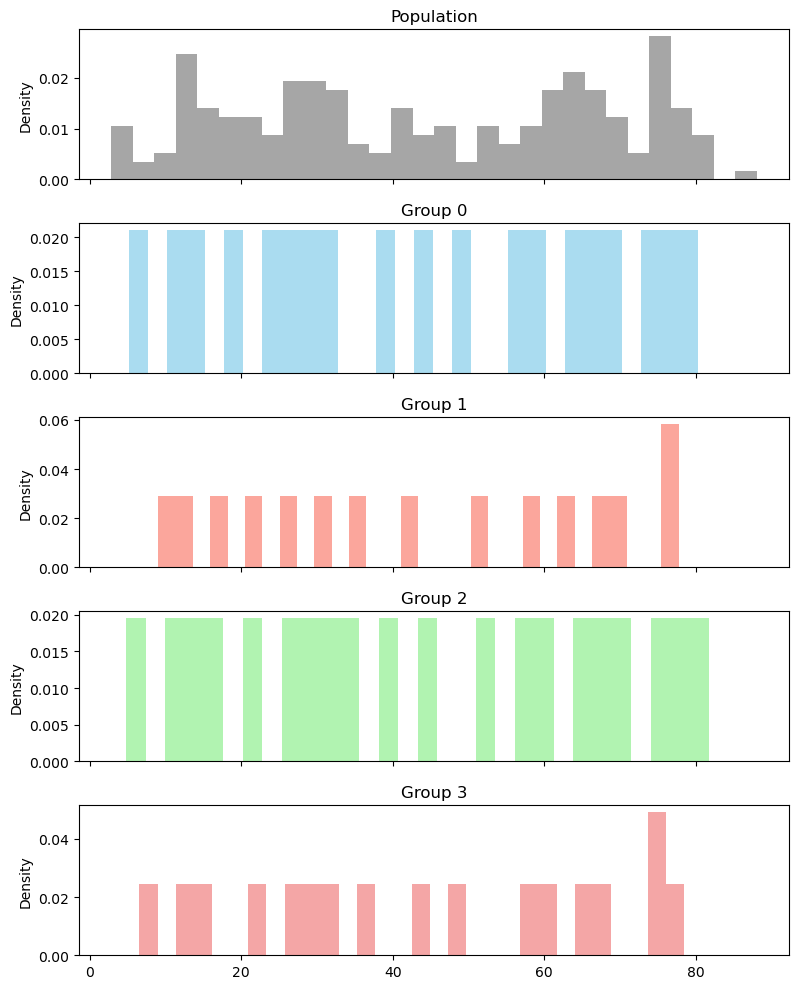

In [100]:
# 3행 히스토그램 시각화
G0_opt = x[groups_random_opt == 0]
G1_opt = x[groups_random_opt == 1]
G2_opt = x[groups_random_opt == 2]
G3_opt = x[groups_random_opt == 3]
G4_opt = x[groups_random_opt == 4]

fig, axes = plt.subplots(5, 1, figsize=(8, 10), sharex=True)

# 모집단 (Population)
axes[0].hist(x, bins=30, density=True, color='gray', alpha=0.7)
axes[0].set_title("Population")
axes[0].set_ylabel("Density")

# 그룹 0
axes[1].hist(G0_opt, bins=30, density=True, color='skyblue', alpha=0.7)
axes[1].set_title("Group 0")
axes[1].set_ylabel("Density")

# 그룹 1
axes[2].hist(G1_opt, bins=30, density=True, color='salmon', alpha=0.7)
axes[2].set_title("Group 1")
axes[2].set_ylabel("Density")

# 그룹 2
axes[3].hist(G2_opt, bins=30, density=True, color='lightgreen', alpha=0.7)
axes[3].set_title("Group 2")
axes[3].set_ylabel("Density")

# 그룹 3
axes[4].hist(G3_opt, bins=30, density=True, color='lightcoral', alpha=0.7)
axes[4].set_title("Group 3")
axes[4].set_ylabel("Density")

plt.tight_layout()
plt.show()

In [102]:
np.mean(x), np.std(x, ddof=1)

(44.283680191629664, 23.411005376634865)

In [103]:
print(np.mean(x[groups_alternate_opt == 0]), np.std(x[groups_alternate_opt == 0], ddof=1), len(x[groups_alternate_opt == 0]))
print(np.mean(x[groups_alternate_opt == 1]), np.std(x[groups_alternate_opt == 1], ddof=1), len(x[groups_alternate_opt == 1]))
print(np.mean(x[groups_alternate_opt == 2]), np.std(x[groups_alternate_opt == 2], ddof=1), len(x[groups_alternate_opt == 2]))
print(np.mean(x[groups_alternate_opt == 3]), np.std(x[groups_alternate_opt == 3], ddof=1), len(x[groups_alternate_opt == 3]))
print(np.mean(x[groups_alternate_opt == 4]), np.std(x[groups_alternate_opt == 4], ddof=1), len(x[groups_alternate_opt == 4]))

43.821097718080296 23.5177556855393 20
43.89141014070716 23.957275792123113 20
44.07468026000678 24.337282973406335 20
44.427370519741785 23.923075382350827 20
44.422490425947515 24.683566314550827 20


In [104]:
print(np.mean(x[groups_random_opt == 0]), np.std(x[groups_random_opt == 0], ddof=1), len(x[groups_random_opt == 0]))
print(np.mean(x[groups_random_opt == 1]), np.std(x[groups_random_opt == 1], ddof=1), len(x[groups_random_opt == 1]))
print(np.mean(x[groups_random_opt == 2]), np.std(x[groups_random_opt == 2], ddof=1), len(x[groups_random_opt == 2]))
print(np.mean(x[groups_random_opt == 3]), np.std(x[groups_random_opt == 3], ddof=1), len(x[groups_random_opt == 3]))
print(np.mean(x[groups_random_opt == 4]), np.std(x[groups_random_opt == 4], ddof=1), len(x[groups_random_opt == 4]))

44.15776025041723 24.054053218669292 19
44.18110667784669 23.706360548559363 15
44.11612854059373 24.087453469389057 20
44.22090840833611 23.68941545156297 17
44.28654013208265 23.959517619540073 25


In [91]:
import seaborn as sns

axes[0].hist(G0_opt, bins=30, density=True, color='skyblue', alpha=0.4)
sns.kdeplot(G0_opt, ax=axes[0], color='blue')

<Axes: title={'center': 'Population'}, ylabel='Density'>

In [218]:
# 모의 데이터 생성
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance, beta, norm
import matplotlib.pyplot as plt

np.random.seed(42)

# 1) [0, 100] 범위의 비정규 혼합 분포 생성
def make_mixture_0_100(n=200, seed=42, mix_ratio=0.65):
    rng = np.random.default_rng(seed)
    n1 = int(n * mix_ratio)
    n2 = n - n1
    comp1 = beta(a=2.0, b=5.0).rvs(size=n1, random_state=seed) * 100.0
    comp2 = np.clip(norm(loc=70.0, scale=8.0).rvs(size=n2, random_state=seed+1), 0.0, 100.0)
    X = np.concatenate([comp1, comp2])
    rng.shuffle(X)
    return X
# 실행
x = make_mixture_0_100(n=232, seed=1, mix_ratio=0.70)

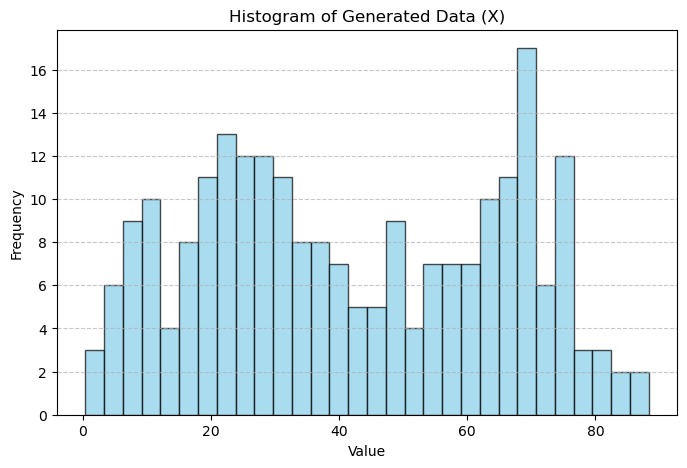

In [219]:
# 모의 데이터 시각화
import matplotlib.pyplot as plt

# 히스토그램 시각화
plt.figure(figsize=(8, 5))
plt.hist(x, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Generated Data (X)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [220]:
len(x)

232

In [221]:
# 초기 그룹 배정
def init_alternate_split(x, k=2):
    order = np.argsort(x) # 오름차순 정렬 했을 때의 순서에서 원래 인덱스 반환
    groups = np.empty(len(x), dtype=int) # 길이가 len(x)인 빈 배열 생성
    for idx, orig_idx in enumerate(order):
        block = (idx // k)  # 현재 몇 번째 블록인지
        pos_in_block = idx % k  # 블록 내 위치
        # 블록 번호가 짝수면 정방향, 홀수면 역방향
        if block % 2 == 0:
            group_id = pos_in_block
        else:
            group_id = k - 1 - pos_in_block
        groups[orig_idx] = group_id
    return groups

groups = init_alternate_split(x, k=10)
groups

array([1, 8, 2, 7, 3, 5, 6, 5, 4, 9, 4, 9, 0, 6, 9, 4, 4, 0, 7, 2, 1, 7,
       4, 6, 8, 2, 2, 2, 9, 1, 6, 3, 9, 6, 5, 2, 7, 0, 2, 0, 5, 1, 5, 3,
       5, 3, 6, 0, 0, 3, 6, 9, 2, 4, 6, 5, 8, 7, 7, 0, 1, 9, 6, 5, 8, 4,
       1, 6, 6, 1, 9, 3, 5, 9, 1, 8, 3, 6, 3, 8, 4, 1, 2, 4, 5, 8, 8, 3,
       6, 9, 5, 1, 8, 1, 5, 9, 1, 8, 5, 0, 2, 7, 5, 4, 0, 8, 0, 2, 6, 7,
       4, 3, 4, 4, 3, 1, 0, 2, 1, 4, 5, 6, 2, 1, 4, 1, 9, 9, 8, 9, 7, 4,
       9, 7, 2, 7, 2, 7, 8, 9, 0, 5, 8, 8, 2, 3, 3, 1, 3, 0, 2, 5, 3, 9,
       4, 7, 2, 1, 2, 9, 1, 2, 5, 4, 2, 6, 9, 7, 3, 9, 1, 7, 8, 5, 0, 8,
       9, 5, 7, 7, 8, 0, 5, 0, 4, 8, 6, 0, 3, 0, 4, 9, 3, 6, 7, 6, 5, 7,
       3, 8, 4, 1, 4, 1, 2, 0, 6, 7, 1, 7, 3, 7, 3, 0, 9, 0, 3, 4, 6, 7,
       6, 3, 6, 8, 8, 2, 0, 0, 8, 9, 8, 5])

In [222]:
def equal_adaptive_binning(x, k): # x : 원본 데이터 (1d 배열)
    x = np.sort(np.asarray(x))
    min_freq = k+2 # 최소 빈도수
    n_bins = max(2, len(x) // min_freq) # 최소 빈도수 고려한 범주 개수
    remainder = len(x) % min_freq
    bin_sizes = [min_freq] * n_bins # 각 범주의 크기
    if remainder > 0:
        bin_sizes[-1] += remainder
    bins_range = []
    start = 0
    for size in bin_sizes:
        end = start + size # 범주의 끝 인덱스 계산
        end = min(end, len(x)) # 범주의 끝 인덱스가 데이터 길이를 넘지 않도록 조정
        bins_range.append((x[start], x[end-1])) # 각 범주의 (최소값, 최대값) 튜플 저장
        start = end # 다음 범주의 시작 인덱스 업데이트
    bin_index = np.zeros(len(x), dtype=int) # 각 데이터 포인트가 속한 범주의 인덱스 담는용
    start = 0
    for idx, size in enumerate(bin_sizes):
        end = start + size
        end = min(end, len(x))
        bin_index[start:end] = idx
        start = end
    return bins_range, bin_index
bins_range, bin_index = equal_adaptive_binning(x, 10)
print(bins_range)
print(len(bins_range), len(x))

# 모 데이터 각 범주별 빈도
bins_key = np.unique(bin_index)
print(bins_key)
bin_counts_dict = {bin_no: 0 for bin_no in bins_key} # 각 범주별 빈도수 초기화
print(bin_counts_dict)
for bin_key, bin_range in zip(bins_key, bins_range):
    low, high = bin_range
    print(low, high)
    count = np.sum((x >= low) & (x <= high))
    bin_counts_dict[bin_key] = count
print(bin_counts_dict)

[(0.35198795797393684, 7.398781366000169), (7.442876319890343, 10.887889211710942), (11.03643400044859, 16.767205430416375), (17.027364457761557, 19.928857002827105), (20.33101509339162, 23.212583631540532), (23.28643035462051, 25.36761123506747), (25.625092126232257, 28.20307357959731), (28.36412677805406, 32.29770598539622), (32.35332639200603, 35.74007866230512), (35.8417569727317, 39.5835026811508), (40.769931962657836, 46.42681666811898), (47.72907101439292, 52.910431234652364), (53.060281920002794, 57.89712772214076), (58.114091906276855, 62.7279390805852), (62.97513685407726, 65.23072240154826), (66.64546814277848, 68.91171353659674), (68.92531891901949, 70.70168174726665), (70.9018120385332, 74.31246656464631), (74.33882057719224, 88.33766410251965)]
19 232
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0}
0.35198795797393684 7.398781366000169
7.4

In [223]:
groups = init_alternate_split(x, k=10)
bins_range, bin_index = equal_adaptive_binning(x, 10)

def bin_based_compute_loss(x, bins_range, bin_index, groups, k):
    # 모 데이터 각 범주별 빈도
    bins_key = np.unique(bin_index)
    pop_bin_counts_dict = {bin_no: 0 for bin_no in bins_key} # 각 범주별 빈도수 초기화
    for bin_key, bin_range in zip(bins_key, bins_range):
        low, high = bin_range
        count = np.sum((x >= low) & (x <= high))
        pop_bin_counts_dict[bin_key] = count
    # 그룹별 범주 빈도수
    group_bin_counts = {f'group_{g_n}': {bin_no: 0 for bin_no in bins_key} for g_n in range(k)} # 각 그룹별 각 범주 빈도수 초기화
    for idx, g_n in enumerate(groups):
        bin_no = bin_index[idx]
        group_bin_counts[f'group_{g_n}'][bin_no] += 1

    print("Population bin counts:", pop_bin_counts_dict)
    print("Group bin counts:", group_bin_counts)
    return pop_bin_counts_dict, group_bin_counts

pop_bin_counts_dict, group_bin_counts = bin_based_compute_loss(x, bins_range, bin_index, groups_alternate_opt, 10)
print(pop_bin_counts_dict)
print(group_bin_counts)

Population bin counts: {0: 12, 1: 12, 2: 12, 3: 12, 4: 12, 5: 12, 6: 12, 7: 12, 8: 12, 9: 12, 10: 12, 11: 12, 12: 12, 13: 12, 14: 12, 15: 12, 16: 12, 17: 12, 18: 16}
Group bin counts: {'group_0': {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 2, 6: 2, 7: 1, 8: 3, 9: 1, 10: 2, 11: 0, 12: 1, 13: 1, 14: 2, 15: 0, 16: 1, 17: 0, 18: 0}, 'group_1': {0: 1, 1: 1, 2: 2, 3: 2, 4: 1, 5: 1, 6: 3, 7: 1, 8: 0, 9: 0, 10: 2, 11: 2, 12: 0, 13: 2, 14: 0, 15: 2, 16: 0, 17: 0, 18: 0}, 'group_2': {0: 3, 1: 1, 2: 0, 3: 0, 4: 1, 5: 2, 6: 1, 7: 1, 8: 0, 9: 2, 10: 1, 11: 1, 12: 0, 13: 1, 14: 2, 15: 4, 16: 0, 17: 0, 18: 0}, 'group_3': {0: 1, 1: 1, 2: 3, 3: 2, 4: 0, 5: 1, 6: 1, 7: 1, 8: 2, 9: 1, 10: 0, 11: 2, 12: 0, 13: 0, 14: 1, 15: 1, 16: 3, 17: 0, 18: 0}, 'group_4': {0: 1, 1: 0, 2: 1, 3: 1, 4: 0, 5: 2, 6: 2, 7: 2, 8: 0, 9: 1, 10: 1, 11: 3, 12: 2, 13: 1, 14: 1, 15: 2, 16: 0, 17: 0, 18: 0}, 'group_5': {0: 2, 1: 2, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 3, 9: 2, 10: 3, 11: 0, 12: 2, 13: 2, 14: 0, 15: 1, 16: 2, 17: 0, 18: 0},

In [224]:
for bin_key, bin_value in pop_bin_counts_dict.items():
    print(bin_key, bin_value)
print("++++++++++++++")

for i in group_bin_counts.keys():
    print(i)
    print(group_bin_counts[i])

0 12
1 12
2 12
3 12
4 12
5 12
6 12
7 12
8 12
9 12
10 12
11 12
12 12
13 12
14 12
15 12
16 12
17 12
18 16
++++++++++++++
group_0
{0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 2, 6: 2, 7: 1, 8: 3, 9: 1, 10: 2, 11: 0, 12: 1, 13: 1, 14: 2, 15: 0, 16: 1, 17: 0, 18: 0}
group_1
{0: 1, 1: 1, 2: 2, 3: 2, 4: 1, 5: 1, 6: 3, 7: 1, 8: 0, 9: 0, 10: 2, 11: 2, 12: 0, 13: 2, 14: 0, 15: 2, 16: 0, 17: 0, 18: 0}
group_2
{0: 3, 1: 1, 2: 0, 3: 0, 4: 1, 5: 2, 6: 1, 7: 1, 8: 0, 9: 2, 10: 1, 11: 1, 12: 0, 13: 1, 14: 2, 15: 4, 16: 0, 17: 0, 18: 0}
group_3
{0: 1, 1: 1, 2: 3, 3: 2, 4: 0, 5: 1, 6: 1, 7: 1, 8: 2, 9: 1, 10: 0, 11: 2, 12: 0, 13: 0, 14: 1, 15: 1, 16: 3, 17: 0, 18: 0}
group_4
{0: 1, 1: 0, 2: 1, 3: 1, 4: 0, 5: 2, 6: 2, 7: 2, 8: 0, 9: 1, 10: 1, 11: 3, 12: 2, 13: 1, 14: 1, 15: 2, 16: 0, 17: 0, 18: 0}
group_5
{0: 2, 1: 2, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 3, 9: 2, 10: 3, 11: 0, 12: 2, 13: 2, 14: 0, 15: 1, 16: 2, 17: 0, 18: 0}
group_6
{0: 1, 1: 0, 2: 2, 3: 1, 4: 2, 5: 1, 6: 1, 7: 0, 8: 2, 9: 1, 10: 1, 11: 0, 12: 2,

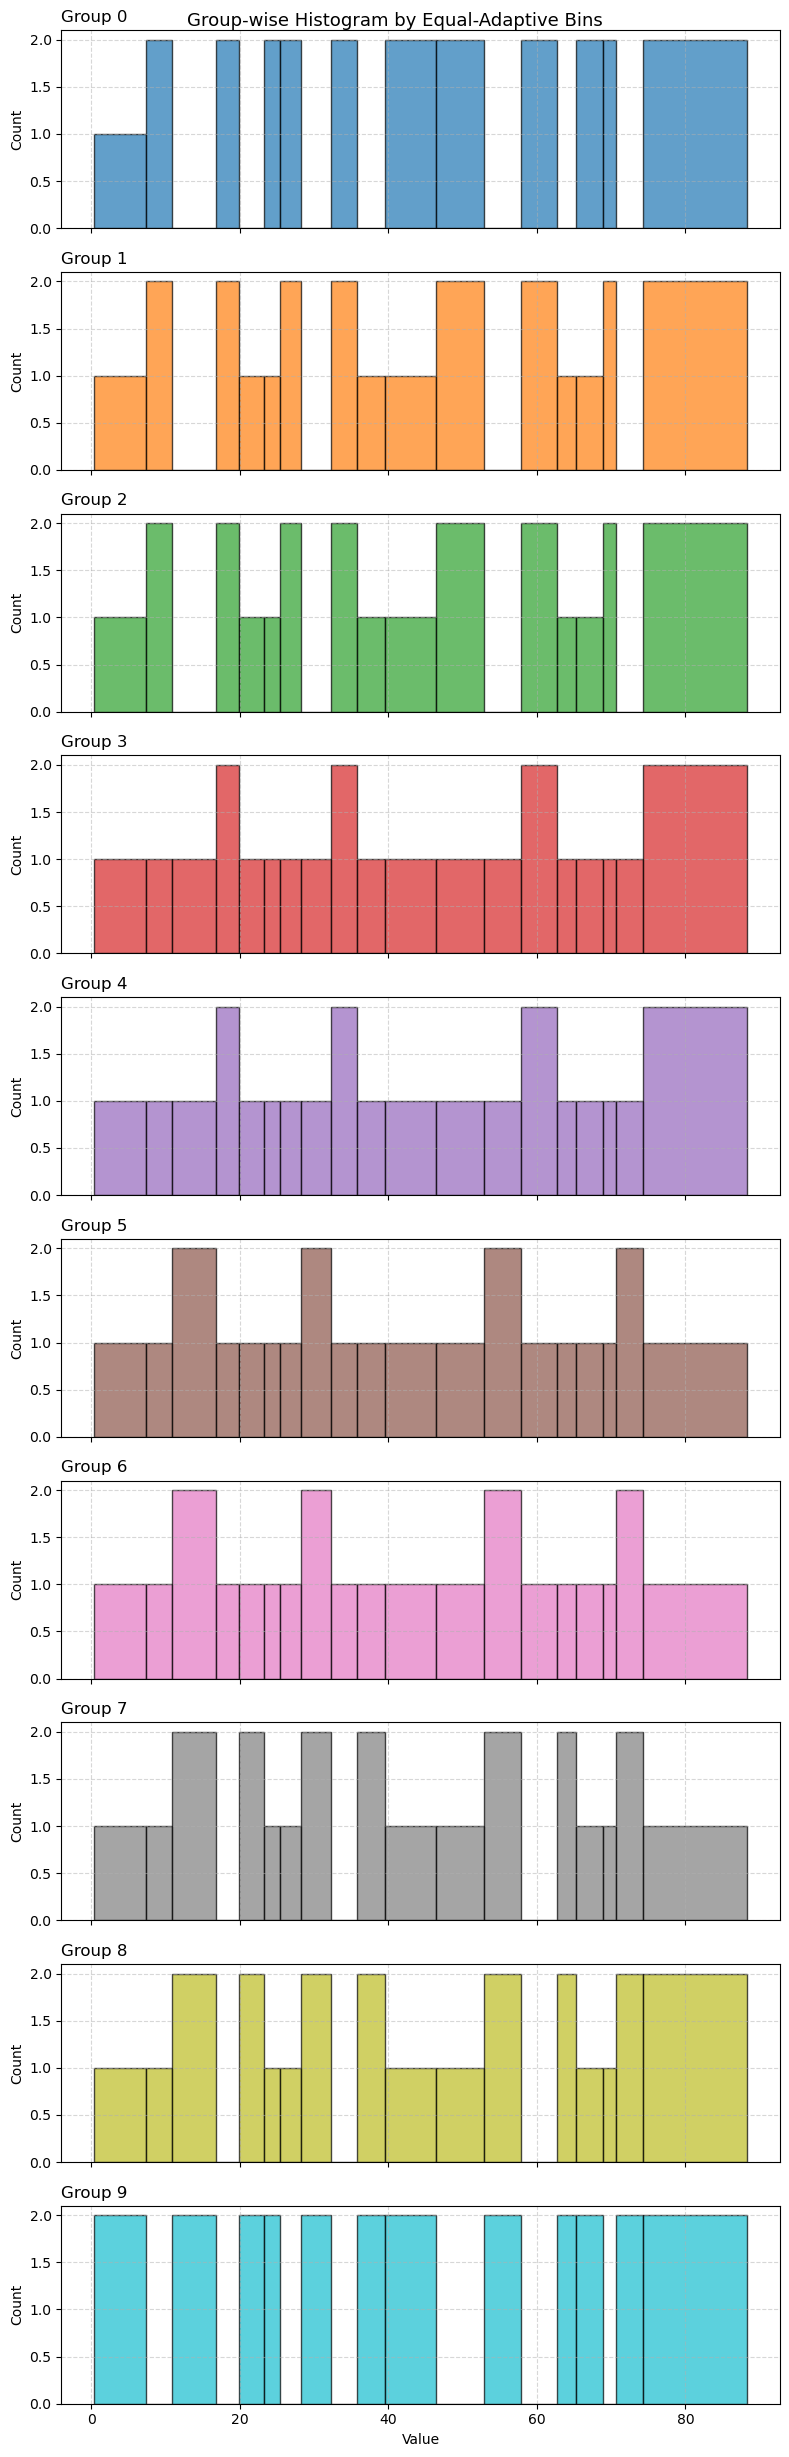

In [225]:
def make_bin_edges_from_range(bins_range):
    edges = [bins_range[0][0]]
    for _, high in bins_range:
        edges.append(high)
    return np.array(edges)

def plot_group_histograms_row(x, groups, bins_range, k):
    bin_edges = make_bin_edges_from_range(bins_range)
    
    fig, axes = plt.subplots(k, 1, figsize=(8, 2.5 * k), sharex=True)
    if k == 1:  # 그룹이 1개일 경우에도 일관성 유지
        axes = [axes]

    for g, ax in enumerate(axes):
        group_data = x[groups == g]
        ax.hist(
            group_data,
            bins=bin_edges,
            color=f"C{g}",
            edgecolor="black",
            alpha=0.7
        )
        ax.set_title(f"Group {g}", loc='left')
        ax.set_ylabel("Count")
        ax.grid(True, linestyle="--", alpha=0.5)

    # x축 설정은 맨 아래 subplot만
    axes[-1].set_xlabel("Value")
    fig.suptitle("Group-wise Histogram by Equal-Adaptive Bins", fontsize=13)
    plt.tight_layout()
    plt.show()

plot_group_histograms_row(x, groups, bins_range, 10)

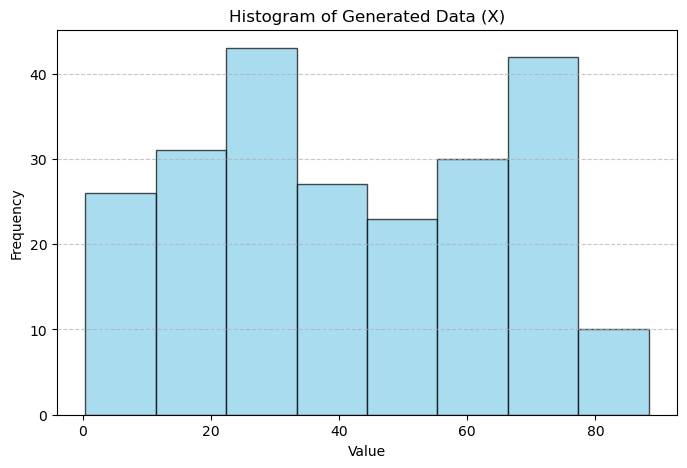

In [212]:
# 모의 데이터 시각화
import matplotlib.pyplot as plt

# 히스토그램 시각화
plt.figure(figsize=(8, 5))
plt.hist(x, bins=8, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Generated Data (X)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 각 규칙별 bin 개수 계산
sturges = int(np.ceil(np.log2(len(x))) + 1)
sqrt_rule = int(np.sqrt(len(x)))

# Freedman–Diaconis Rule
iqr = np.percentile(x, 75) - np.percentile(x, 25)
fd_bin_width = 2 * iqr / (len(x) ** (1/3))
fd_bins = int(np.ceil((x.max() - x.min()) / fd_bin_width))

# Scott’s Rule
std = np.std(x)
scott_bin_width = 3.5 * std / (len(x) ** (1/3))
scott_bins = int(np.ceil((x.max() - x.min()) / scott_bin_width))

print(f"Sturges: {sturges}, FD: {fd_bins}, Scott: {scott_bins}, √n: {sqrt_rule}")

Sturges: 9, FD: 7, Scott: 7, √n: 15


In [226]:
for group in range(10):
    point = x[groups == group]
    print(f"Group {group}: n={len(point)}, mean={np.mean(point):.2f}, std={np.std(point, ddof=1):.2f}")

Group 0: n=23, mean=41.19, std=23.26
Group 1: n=23, mean=41.20, std=23.24
Group 2: n=23, mean=41.42, std=23.27
Group 3: n=23, mean=41.55, std=23.34
Group 4: n=23, mean=41.57, std=23.36
Group 5: n=23, mean=41.56, std=23.47
Group 6: n=23, mean=41.67, std=23.52
Group 7: n=23, mean=41.80, std=23.59
Group 8: n=24, mean=43.76, std=25.03
Group 9: n=24, mean=43.85, std=25.05


In [211]:
# find_bin_value
x = np.sort(np.asarray(x))
n = len(x)
k = 10
print(n)

max_bin = None
if max_bin is None:
    max_bin = n // 2

for n_bin in range(2, max_bin + 1):
    print(f"Trying n_bin={n_bin}")
    count, edges = np.histogram(x, bins=n_bin)
    print(count)
    print(edges)
    min_count = count.min()
    if min_count == k:
        print(f"n_bin: {n_bin}, min_count: {min_count}, edges: {edges}")
        break
print("No suitable bin count found.")

232
Trying n_bin=2
[127 105]
[ 0.35198796 44.34482603 88.3376641 ]
Trying n_bin=3
[88 71 73]
[ 0.35198796 29.68054667 59.00910539 88.3376641 ]
Trying n_bin=4
[57 70 53 52]
[ 0.35198796 22.34840699 44.34482603 66.34124507 88.3376641 ]
Trying n_bin=5
[40 67 38 59 28]
[ 0.35198796 17.94912319 35.54625842 53.14339364 70.74052887 88.3376641 ]
Trying n_bin=6
[32 56 39 32 51 22]
[ 0.35198796 15.01626732 29.68054667 44.34482603 59.00910539 73.67338475
 88.3376641 ]
Trying n_bin=7
[30 42 42 28 27 51 12]
[ 0.35198796 12.92137026 25.49075257 38.06013488 50.62951718 63.19889949
 75.7682818  88.3376641 ]
Trying n_bin=8
[26 31 43 27 23 30 42 10]
[ 0.35198796 11.35019748 22.34840699 33.34661651 44.34482603 55.34303555
 66.34124507 77.33945458 88.3376641 ]
n_bin: 8, min_count: 10, edges: [ 0.35198796 11.35019748 22.34840699 33.34661651 44.34482603 55.34303555
 66.34124507 77.33945458 88.3376641 ]
No suitable bin count found.


In [ ]:
# 초기 그룹 배정
def init_alternate_split(x, k=2):
    order = np.argsort(x) # 오름차순 정렬 했을 때의 순서에서 원래 인덱스 반환
    groups = np.empty(len(x), dtype=int) # 길이가 len(x)인 빈 배열 생성
    for order_idx, order_value in enumerate(order): # order_idx : order의 인덱스(그룹 배정용), order_value : order의 값(크기순으로 정렬된 원래 인덱스)
        groups[order_value] = order_idx % k # 그룹 배정 (원 데이터 맵핑용)
    return groups

# 모집단 적응형 범주화(bin) Equal-Frequency Binning (Quantile Binning)
# 범주내 데이터 수가 최소 그룹 수 만큼은 되어야함. 그래야 범주별 최소 하나 이상 배정 가능
# 그룹 수 + extra (2~3) 정도 여유둬서 추후 포인트 스왑시 범주내 데이터 수 부족 문제 방지
def equal_adaptive_binning(x, k): # x : 원본 데이터 (1d 배열)
    x = np.sort(np.asarray(x))
    min_freq = k+2 # 최소 빈도수
    n_bins = max(2, len(x) // min_freq) # 최소 빈도수 고려한 범주 개수
    remainder = len(x) % min_freq
    bin_sizes = [min_freq] * n_bins # 각 범주의 크기
    if remainder > 0:
        bin_sizes[-1] += remainder
    bins_range = []
    start = 0
    for size in bin_sizes:
        end = start + size # 범주의 끝 인덱스 계산
        end = min(end, len(x)) # 범주의 끝 인덱스가 데이터 길이를 넘지 않도록 조정
        bins_range.append((x[start], x[end-1])) # 각 범주의 (최소값, 최대값) 튜플 저장
        start = end # 다음 범주의 시작 인덱스 업데이트
    bin_index = np.zeros(len(x), dtype=int) # 각 데이터 포인트가 속한 범주의 인덱스 담는용
    start = 0
    for idx, size in enumerate(bin_sizes):
        end = start + size
        end = min(end, len(x))
        bin_index[start:end] = idx
        start = end
    return bins_range, bin_index

# 초기 그룹 배정 후
# equal_adaptive_binning 된 후
# bin 기준 그룹별 카운팅해서 스왑 최적화 진행
def bin_based_compute_loss(x, bins_range, bin_index, groups, k):
    # 모 데이터 각 범주별 빈도
    bins_key = np.unique(bin_index)
    pop_bin_counts_dict = {bin_no: 0 for bin_no in bins_key} # 각 범주별 빈도수 초기화
    for bin_key, bin_range in zip(bins_key, bins_range):
        low, high = bin_range
        count = np.sum((x >= low) & (x <= high))
        pop_bin_counts_dict[bin_key] = count
    # 그룹별 범주 빈도수
    group_bin_counts = {f'group_{g_n}': {bin_no: 0 for bin_no in bins_key} for g_n in range(k)} # 각 그룹별 각 범주 빈도수 초기화
    for idx, g_n in enumerate(groups):
        bin_no = bin_index[idx]
        group_bin_counts[f'group_{g_n}'][bin_no] += 1

    print("Population bin counts:", pop_bin_counts_dict)
    print("Group bin counts:", group_bin_counts)
    return pop_bin_counts_dict, group_bin_counts

# 손실함수: ∑ W1(그룹, 모집단) + 균형 패널티
def compute_loss(x, groups, k=2, lam=5.0): # x : 원본 데이터, groups : 그룹 배정 정보, k : 그룹 수, lam : 균형 패널티 계수
    loss = 0.0 # 전체 손실값 초기화
    n = len(x) # 데이터 수
    for g_n in range(k): # 0,1
        group_k = x[groups == g_n] # [groups == g_n] : groups 배열에서 g_n인 인덱스의 불리언 배열 마스크 반환
        if len(group_k) == 0:
            return 1e12
        loss += wasserstein_distance(group_k, x) # group_k와 원본 데이터 x 간의 확률분포 차이 계산 -> for문 돌면서 각 그룹에 대해 누적
    size_penalty = 0.0 # 균형 패널티 초기화
    for g_n in range(k):
        size_ratio = np.sum(groups == g_n)/k # 모집단에서 해당 그룹의 비율
        ideal_ratio = 1.0/k # 이상적인 그룹 비율
        size_penalty += abs(size_ratio - ideal_ratio) # 그룹 크기 차이의 절대값 누적
    return loss + lam * size_penalty

# 스왑 최적화
def optimize_by_swaps(x, k=2, lam=5.0, max_iters=15000, temp_start=0.02, temp_end=0.001, seed=1, init="random"):
    rng = np.random.default_rng(seed) # 난수 생성
    n = len(x) # 데이터 수
    groups = init_random_split(n, k, seed) if init=="random" else init_alternate_split(x, k) # 초기 그룹 배정
    best_groups = groups.copy()
    best_loss = compute_loss(x, groups, k, lam) # 초기 손실값 계산 x : 원본 데이터, groups : 그룹 배정 정보, k : 그룹 수, lam : 균형 패널티 계수
    #print(f"Initial loss: {best_loss:.4f}")
    def temperature(t):
        return temp_start + (temp_end - temp_start) * (t / max_iters)
    for t in range(max_iters):
        i, j = rng.integers(0, n), rng.integers(0, n) # 스왑할 두 인덱스 무작위 선택
        if groups[i] == groups[j]: # 같은 그룹이면 스왑 안함
            pass
        else:
            # 다른 그룹이면 스왑 시도
            gi, gj = groups[i], groups[j]
            groups[i], groups[j] = gj, gi
            new_loss = compute_loss(x, groups, k, lam)
            delta = new_loss - best_loss
            # 개선되었으면 수용
            if delta <= 0:
                print(f"Improved loss at iter {t}, delta: {delta:.4f}")
                best_loss = new_loss
                best_groups = groups.copy()
            else:
                T = temperature(t)
                if rng.random() < np.exp(-delta / max(T, 1e-12)):
                    print(f"Accepted swap at iter {t}, delta: {delta:.4f}, temp: {T:.6f}")
                    best_loss = new_loss
                    best_groups = groups.copy()
                else:
                    print(f"Rejected swap at iter {t}, delta: {delta:.4f}, temp: {T:.6f}")
                    groups[i], groups[j] = gi, gj
    return best_groups, best_loss

여기서부터 다시 설계

In [ ]:
# 모의 데이터 생성
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance, beta, norm
import matplotlib.pyplot as plt

# 1) [0, 100] 범위의 비정규 혼합 분포 생성
def make_mixture_0_100(n=200, seed=42, mix_ratio=0.65):
    rng = np.random.default_rng(seed)
    n1 = int(n * mix_ratio)
    n2 = n - n1
    comp1 = beta(a=2.0, b=5.0).rvs(size=n1, random_state=seed) * 100.0
    comp2 = np.clip(norm(loc=70.0, scale=8.0).rvs(size=n2, random_state=seed+1), 0.0, 100.0)
    X = np.concatenate([comp1, comp2])
    rng.shuffle(X)
    return np.round(X).astype(int)
# 실행
x = make_mixture_0_100(n=232, seed=2, mix_ratio=0.72)

모집단 기준 bin 개수: 7


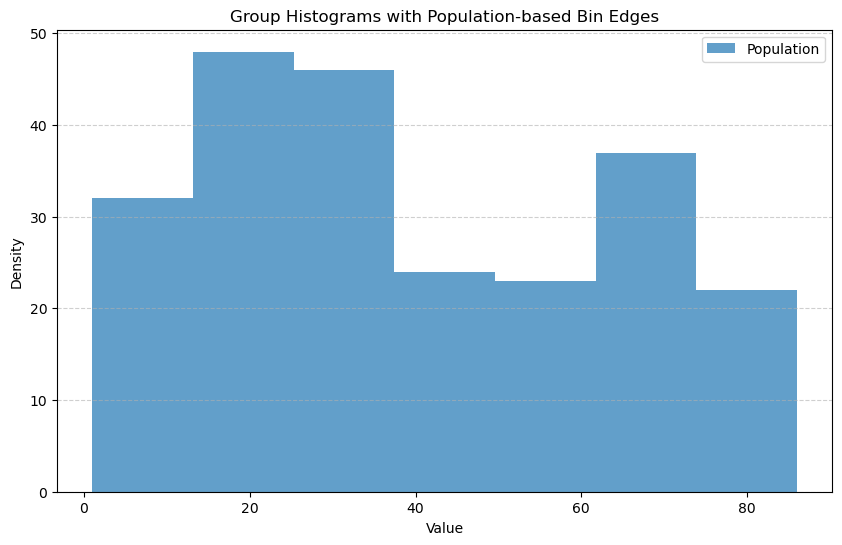

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ 모집단에서 적절한 bin 엣지 추정
bin_edges = np.histogram_bin_edges(x, bins='fd')  # Freedman–Diaconis rule 기반
print(f"모집단 기준 bin 개수: {len(bin_edges)-1}")

# 2️⃣ 모집단 및 그룹별 시각화 (bin 엣지 고정)
plt.figure(figsize=(10, 6))

plt.hist(x, bins=bin_edges, alpha=0.7, label='Population', density=False)

plt.title("Group Histograms with Population-based Bin Edges")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

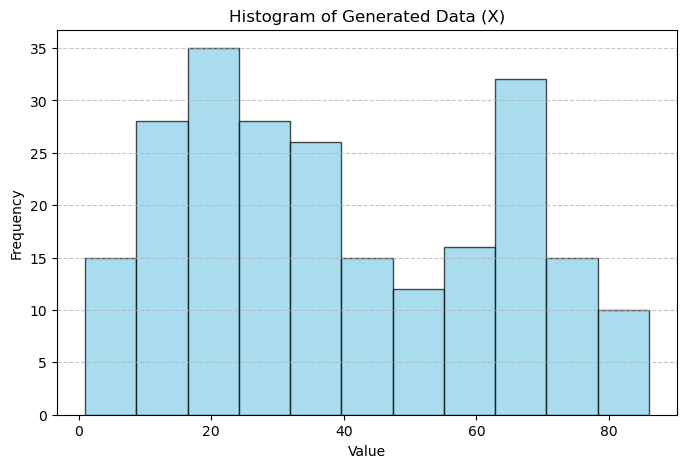

In [117]:
# 모의 데이터 시각화
import matplotlib.pyplot as plt

# 히스토그램 시각화
plt.figure(figsize=(8, 5))
counts, bin_edges, _  = plt.hist(x, bins=11, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Generated Data (X)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [46]:
# 초기 그룹 배정
def init_alternate_split(x, k=2):
    order = np.argsort(x) # 오름차순 정렬 했을 때의 순서에서 원래 인덱스 반환
    groups = np.empty(len(x), dtype=int) # 길이가 len(x)인 빈 배열 생성
    for idx, orig_idx in enumerate(order):
        block = (idx // k)  # 현재 몇 번째 블록인지
        pos_in_block = idx % k  # 블록 내 위치
        # 블록 번호가 짝수면 정방향, 홀수면 역방향
        if block % 2 == 0:
            group_id = pos_in_block
        else:
            group_id = k - 1 - pos_in_block
        groups[orig_idx] = group_id
    return groups

groups = init_alternate_split(x, k=10)
groups

array([1, 8, 8, 2, 9, 3, 1, 3, 5, 0, 3, 1, 6, 0, 1, 1, 6, 4, 1, 0, 5, 5,
       7, 1, 1, 6, 1, 9, 2, 7, 2, 6, 4, 4, 8, 9, 9, 4, 8, 9, 5, 6, 5, 0,
       5, 6, 7, 8, 6, 2, 7, 4, 9, 1, 4, 8, 3, 3, 0, 0, 9, 1, 2, 9, 8, 7,
       9, 1, 3, 7, 0, 4, 4, 4, 7, 9, 9, 5, 4, 8, 6, 7, 0, 6, 3, 7, 4, 0,
       3, 5, 7, 0, 5, 0, 2, 1, 2, 8, 2, 3, 9, 0, 6, 3, 7, 6, 5, 5, 6, 7,
       2, 8, 4, 8, 6, 7, 2, 0, 0, 5, 8, 5, 3, 3, 6, 0, 4, 8, 4, 6, 0, 7,
       6, 6, 0, 3, 1, 2, 9, 4, 6, 2, 9, 8, 5, 5, 6, 4, 3, 0, 7, 8, 7, 1,
       8, 9, 6, 1, 9, 0, 8, 3, 1, 3, 6, 9, 8, 8, 5, 6, 5, 1, 2, 4, 7, 7,
       0, 2, 7, 9, 0, 8, 0, 2, 3, 2, 6, 5, 9, 2, 5, 2, 3, 9, 8, 1, 2, 3,
       4, 2, 2, 7, 1, 7, 8, 2, 1, 1, 4, 9, 4, 5, 3, 3, 0, 4, 3, 9, 1, 8,
       4, 8, 9, 5, 4, 2, 5, 9, 7, 3, 5, 7])

In [47]:
# 초기 그룹 배정한 대표 통계치
for group in range(10):
    point = x[groups == group]
    print(f"Group {group}: n={len(point)}, mean={np.mean(point):.2f}, std={np.std(point, ddof=1):.2f}")

Group 0: n=23, mean=38.91, std=23.46
Group 1: n=23, mean=38.91, std=23.30
Group 2: n=23, mean=38.87, std=23.50
Group 3: n=23, mean=39.09, std=23.33
Group 4: n=23, mean=39.13, std=23.28
Group 5: n=23, mean=39.00, std=23.37
Group 6: n=23, mean=39.17, std=23.34
Group 7: n=23, mean=39.17, std=23.43
Group 8: n=24, mean=41.33, std=25.01
Group 9: n=24, mean=41.17, std=24.86


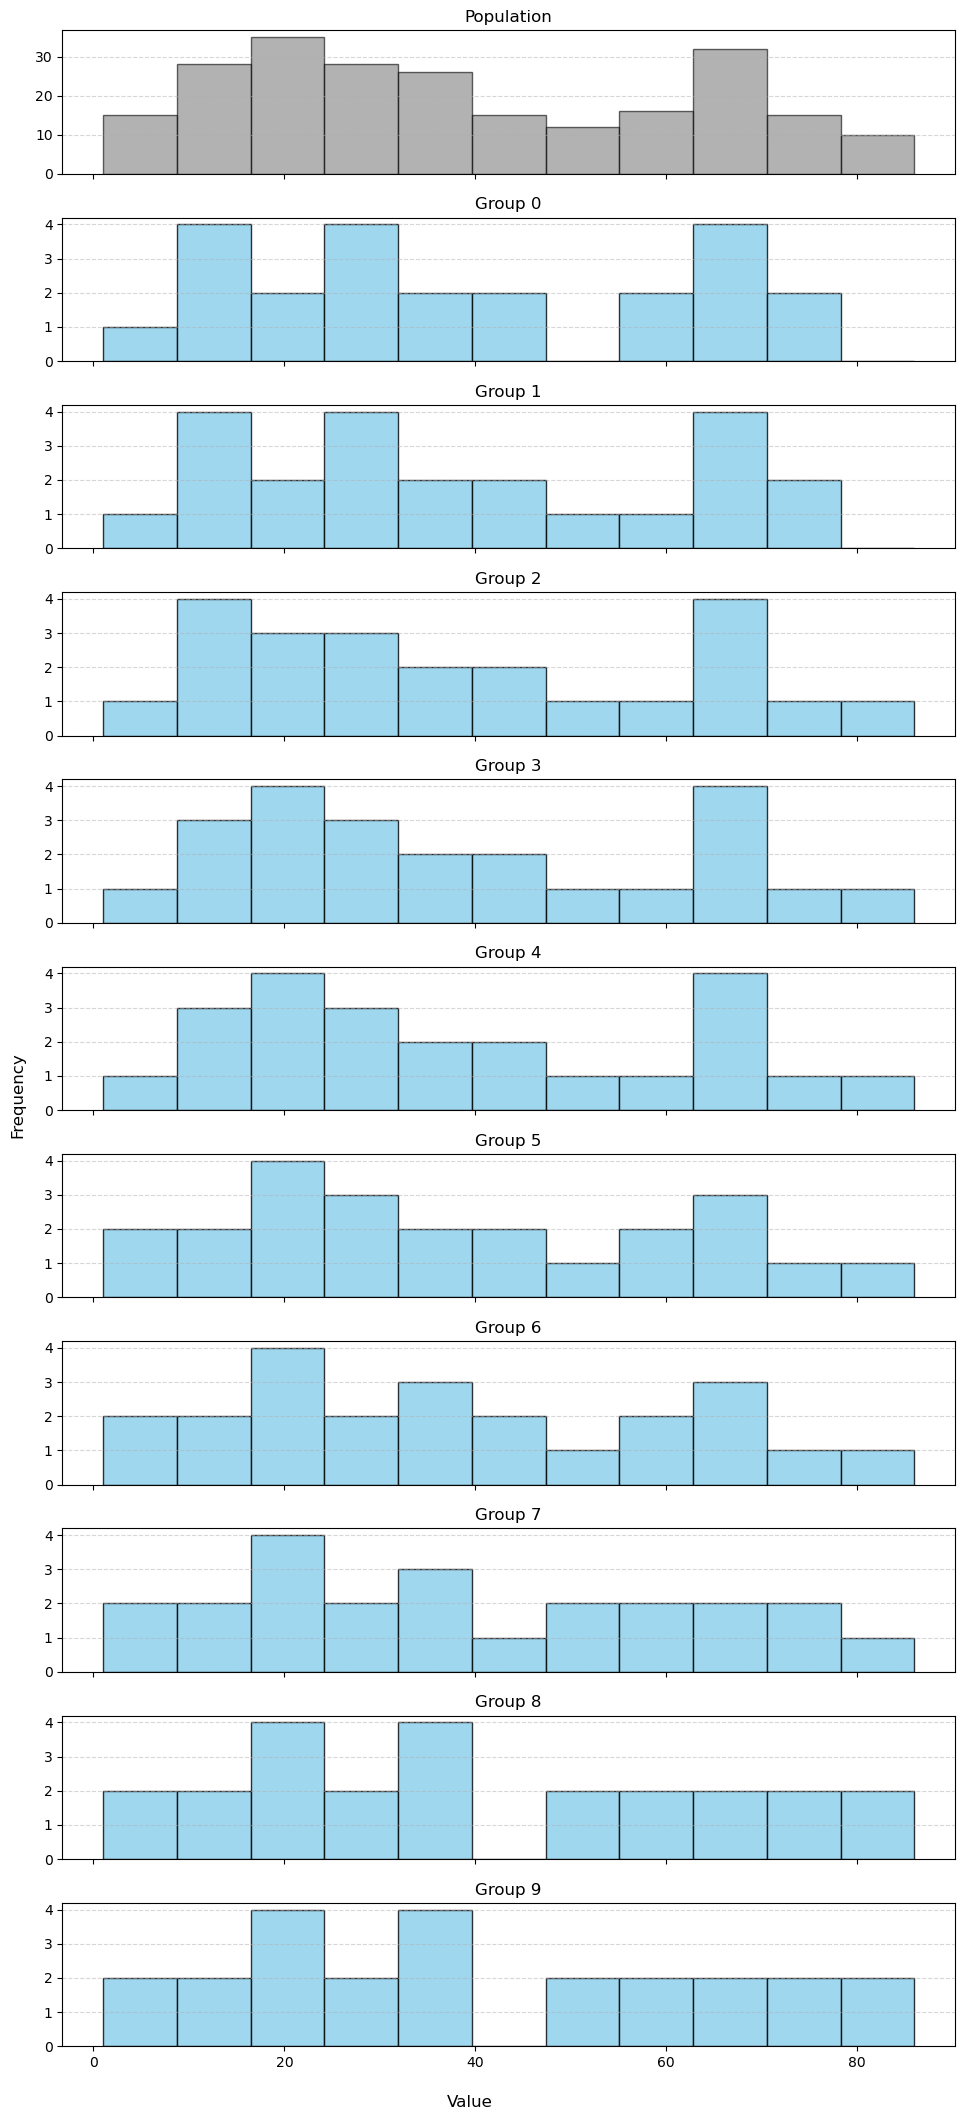

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# 모집단 히스토그램 그릴 때 사용된 bin_edges 재사용
fig, axes = plt.subplots(
    nrows=len(np.unique(groups)) + 1,  # 모집단 + 그룹 수
    ncols=1,
    figsize=(10, 2 * (len(np.unique(groups)) + 1)),  # 전체 높이 자동 조절
    sharex=True,  # x축 공유
)

# 1️⃣ 모집단
axes[0].hist(x, bins=bin_edges, color='gray', edgecolor='black', alpha=0.6)
axes[0].set_title("Population", fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# 2️⃣ 그룹별 히스토그램
for i, g in enumerate(np.unique(groups), start=1):
    axes[i].hist(x[groups == g], bins=bin_edges, color='skyblue', edgecolor='black', alpha=0.8)
    axes[i].set_title(f"Group {g}", fontsize=12)
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

# 공통 x/y 라벨 설정
fig.text(0.5, 0.04, 'Value', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()

분포 형태가 깨지게 나옴

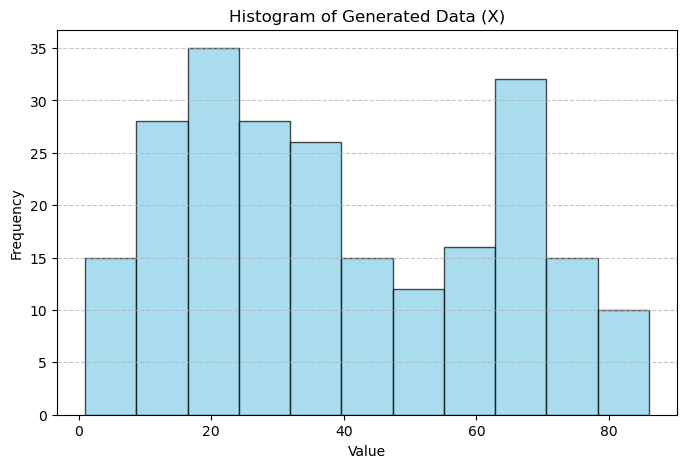

[15. 28. 35. 28. 26. 15. 12. 16. 32. 15. 10.]
[ 1.          8.72727273 16.45454545 24.18181818 31.90909091 39.63636364
 47.36363636 55.09090909 62.81818182 70.54545455 78.27272727 86.        ]


In [146]:
# 히스토그램 시각화
plt.figure(figsize=(8, 5))
counts, bin_edges, _  = plt.hist(x, bins=11, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Generated Data (X)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print(counts)
print(bin_edges)

In [147]:
sorted_x_view = np.sort(x)
print(sorted_x_view)

[ 1  2  2  3  4  4  5  5  6  6  7  7  7  7  8  9  9  9 10 10 10 11 11 11
 11 12 12 12 13 13 13 13 14 14 14 15 15 15 16 16 16 16 16 17 17 17 17 18
 18 18 18 19 19 20 20 20 20 20 20 20 21 21 21 22 22 22 22 22 22 22 23 23
 23 24 24 24 24 24 25 25 26 26 26 27 27 27 27 27 27 28 28 28 28 28 28 29
 29 29 29 29 29 29 30 30 30 31 33 33 33 33 34 34 34 34 34 35 35 35 35 36
 36 36 36 36 37 37 38 38 38 38 38 39 40 40 40 40 41 41 42 43 44 44 45 46
 46 46 47 48 49 49 50 51 51 52 52 54 55 55 55 56 56 57 57 58 58 59 60 60
 61 61 61 61 61 62 62 63 63 64 64 64 64 65 65 65 65 65 65 66 66 66 67 67
 67 67 68 68 68 68 68 68 69 69 69 69 70 70 70 71 72 73 74 75 75 75 76 77
 77 77 77 78 78 78 79 79 79 81 82 82 84 84 84 86]


In [148]:
# bin 기준 그룹 수 만큼 나온걸 기준으로 했을 때 11이고
# 그렇다면 각 bin별로 그룹에 배정하면서 진행한다면?
bin_edges = np.histogram_bin_edges(x, bins=11)
print(bin_edges)

[ 1.          8.72727273 16.45454545 24.18181818 31.90909091 39.63636364
 47.36363636 55.09090909 62.81818182 70.54545455 78.27272727 86.        ]


In [149]:
bin_idx = np.digitize(x, bin_edges, right=False) - 1  # bin index (0~bins-1)
print(bin_idx)
print(np.unique(bin_idx, return_counts=True)) # 각 bin별 데이터 수

[ 0  3  3  2  3  3  9 10  5  4  6  8  4  7  2  1  8  1  9  5  7  4  6  7
  8  9  6  1 10  0  6  0  8  2  0  4  7  1  2 10  3  2  8  2  6  2  4  7
  4  8  1  4  0  1  5  7  8  2  8  1  8  1  3  9  2  2  2  5  1  4  5  2
  7  6  9  4  4  7  1  2  5  5  3  5  8  2  8  8  2  5 10  4  2  1  0  3
  1  6  4  9  6  1 10  7  8  2  8  8  8  1  3  1  5 11  7  3  9  7  8  0
  6  3  5  5  8  1 10 10  0  4  9  6  7  1  0  3  2  1  7  2  0  3  0  8
 10  1  1  8  8  3  8  0  4  1  9  9  2  5  6  3  4  2  3  3  3 10  8  4
  9  3  3  4  2  3  3  7  8  2  0  2  2  4  3  8  4  1  6  4  2  7  1  8
  1  8  9  8  4  1  3  5  8  2  4  2  4  5  8  3  2  1  4  0  2  4  9  9
  8  4  3  2  3  1  3  2  8  1  2  2  7  0  2  9]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([15, 28, 35, 28, 26, 15, 12, 16, 32, 15,  9,  1]))


In [150]:
bin_idx[x >= bin_edges[-1]] = len(bin_edges) - 2
print(bin_idx)
print(np.unique(bin_idx, return_counts=True)) # 각 bin별 데이터 수

[ 0  3  3  2  3  3  9 10  5  4  6  8  4  7  2  1  8  1  9  5  7  4  6  7
  8  9  6  1 10  0  6  0  8  2  0  4  7  1  2 10  3  2  8  2  6  2  4  7
  4  8  1  4  0  1  5  7  8  2  8  1  8  1  3  9  2  2  2  5  1  4  5  2
  7  6  9  4  4  7  1  2  5  5  3  5  8  2  8  8  2  5 10  4  2  1  0  3
  1  6  4  9  6  1 10  7  8  2  8  8  8  1  3  1  5 10  7  3  9  7  8  0
  6  3  5  5  8  1 10 10  0  4  9  6  7  1  0  3  2  1  7  2  0  3  0  8
 10  1  1  8  8  3  8  0  4  1  9  9  2  5  6  3  4  2  3  3  3 10  8  4
  9  3  3  4  2  3  3  7  8  2  0  2  2  4  3  8  4  1  6  4  2  7  1  8
  1  8  9  8  4  1  3  5  8  2  4  2  4  5  8  3  2  1  4  0  2  4  9  9
  8  4  3  2  3  1  3  2  8  1  2  2  7  0  2  9]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([15, 28, 35, 28, 26, 15, 12, 16, 32, 15, 10]))


In [142]:
# 전체 데이터 정렬해서 원본 인덱스
origin_index = np.argsort(x)
print(origin_index)
groups = np.empty(len(x), dtype=int)

[134   0  94 229 128 119  31  29  34 142  52 151 178 140 211  78  68  96
  15  93 125 153 137 192  37 145 146 109 221  27 209 111  50 133 190  17
 197 185  53  59 101  61 225  57  33 223  41  65  79 227 179  38 203 105
  92 139  88   3  14 180  43 136 177 212 208 230  45  85  64  66 188 219
 201 156 226  71 161 172 162 149 159 218 110 135 173 170 164 115   1   4
 222   2 174 169 121 198   5  62  95  82 182 207 141 163 220  40  48  46
 181  35  76 160 152 129  21 210 184  98 171  91   9 202 196 213  51 187
  12  69 204 217  75 167  81  80   8  54 123 199 157  19  70  67 205 122
 112  89  83 131 120 100 158  97  22 186  44  73  10  30  26 117  13  23
 189 103  72  20 132 175  55  36 138  47 228 114  77 224 216 183 195 176
  87 206  49 148 147 106 108 104 143  60 193 166 150  16 107  32  56 191
  11  58 118  24 200  84  86  42 124  74 194 155  63 154 231  25 168 215
  99 116   6 130 214  18  28   7 126 144 102  90 127  39 165 113]


In [143]:
indices_in_bin = np.where(bin_idx == 0)[0] # bin 0에 속하는 데이터의 오리진 인덱스
print(indices_in_bin)

[  0  29  31  34  52  94 119 128 134 140 142 151 178 211 229]


In [144]:
sorted_idx_within_bin = indices_in_bin[np.argsort(x[indices_in_bin])]
print(sorted_idx_within_bin)

[134   0  94 229 119 128  29  31  34 142  52 140 151 178 211]


In [145]:
groups

array([                   0,           4294967543,                    0,
                 4380248055,           5810368024,                    1,
                         -1,                    2,  4189044133941215277,
                -4294967296,           4380247920,           5819119375,
                38654705665,                    0,                    2,
        7957684001227931732,          -4294967296,           5150409904,
                 5819119378,          34359738369,                   56,
                          2,  4190925316731961402,          -4294967296,
                 5150409952,           5819119381,          34359738369,
                        112,                    2,  7310019992601231418,
                -4294967296,           5150410000,           5819119384,
                34359738369,                  168,                    2,
        8675445210654536303,          -4294967296,           5150410048,
                 5819119387,          34359738369, 

In [115]:
for i, idx in enumerate(sorted_idx_within_bin):
    groups[idx] = i % 10

In [116]:
groups

array([          1,           9,           2,           3,           4,
                 8,           8,          11,           0,           5,
                 9,           1,           3,           0,           5,
                 3,           6,           1,           2,           7,
                 6,           5,           4,           2,           6,
                 4,           0,           5, 17179869188,           6,
                 1,           7,           0,           0,           8,
                 0,           9,           8,           8,           0,
                 7,           1,           9,           9,           6,
                 2,           1,           0,           2,           1,
                 8,           9,           0,           5,           1,
                 1,           2,           3,           3,           4,
                 3,           3,           3,           3,           1,
                 5,           0,           8,           0,      

In [154]:
bin_edges = np.histogram_bin_edges(x, bins=11)
print(bin_edges)

bin_idx = np.digitize(x, bin_edges, right=False) - 1  # bin index (0~bins-1)
bin_idx[x >= bin_edges[-1]] = len(bin_edges) - 2
print(np.unique(bin_idx, return_counts=True)) # 각 bin별 데이터 수

# 전체 데이터 정렬해서 원본 인덱스
origin_index = np.argsort(x)
print(origin_index)
groups = np.empty(len(x), dtype=int)

for b in range(11):
    print(b)
    indices_in_bin = np.where(bin_idx == b)[0] # bin 0에 속하는 데이터의 오리진 인덱스
    #print(indices_in_bin)

    sorted_idx_within_bin = indices_in_bin[np.argsort(x[indices_in_bin])]
    print(sorted_idx_within_bin)

    for i, idx in enumerate(sorted_idx_within_bin):
        groups[idx] = i % 10
    print(groups)
groups

[ 1.          8.72727273 16.45454545 24.18181818 31.90909091 39.63636364
 47.36363636 55.09090909 62.81818182 70.54545455 78.27272727 86.        ]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([15, 28, 35, 28, 26, 15, 12, 16, 32, 15, 10]))
[134   0  94 229 128 119  31  29  34 142  52 151 178 140 211  78  68  96
  15  93 125 153 137 192  37 145 146 109 221  27 209 111  50 133 190  17
 197 185  53  59 101  61 225  57  33 223  41  65  79 227 179  38 203 105
  92 139  88   3  14 180  43 136 177 212 208 230  45  85  64  66 188 219
 201 156 226  71 161 172 162 149 159 218 110 135 173 170 164 115   1   4
 222   2 174 169 121 198   5  62  95  82 182 207 141 163 220  40  48  46
 181  35  76 160 152 129  21 210 184  98 171  91   9 202 196 213  51 187
  12  69 204 217  75 167  81  80   8  54 123 199 157  19  70  67 205 122
 112  89  83 131 120 100 158  97  22 186  44  73  10  30  26 117  13  23
 189 103  72  20 132 175  55  36 138  47 228 114  77 224 216 183 195 176
  87 206  49 148

array([1, 9, 2, 3, 4, 8, 8, 0, 0, 5, 9, 1, 3, 0, 5, 3, 6, 1, 2, 7, 6, 5,
       4, 2, 6, 4, 0, 5, 1, 6, 1, 7, 0, 0, 8, 0, 9, 8, 8, 6, 7, 1, 9, 9,
       6, 2, 1, 0, 2, 1, 8, 9, 0, 5, 1, 1, 2, 3, 3, 4, 3, 3, 3, 3, 1, 5,
       0, 8, 0, 1, 9, 3, 4, 8, 0, 0, 6, 4, 1, 7, 2, 3, 7, 4, 8, 5, 1, 5,
       1, 1, 4, 7, 0, 5, 2, 2, 2, 5, 1, 9, 1, 6, 5, 5, 2, 4, 9, 4, 0, 2,
       4, 4, 2, 9, 5, 0, 0, 1, 5, 4, 2, 1, 3, 4, 0, 4, 2, 7, 5, 4, 3, 0,
       7, 7, 0, 8, 8, 9, 2, 2, 1, 6, 9, 4, 3, 1, 0, 8, 7, 0, 5, 2, 7, 7,
       5, 2, 0, 6, 3, 3, 8, 1, 1, 4, 7, 8, 8, 5, 7, 5, 6, 2, 2, 5, 3, 8,
       4, 7, 3, 6, 6, 3, 9, 3, 0, 0, 7, 8, 7, 3, 9, 9, 6, 7, 1, 2, 4, 2,
       0, 5, 7, 8, 3, 9, 2, 0, 6, 1, 3, 6, 9, 4, 4, 6, 4, 1, 1, 4, 2, 9,
       5, 3, 6, 2, 0, 7, 4, 4, 3, 3, 6, 6])

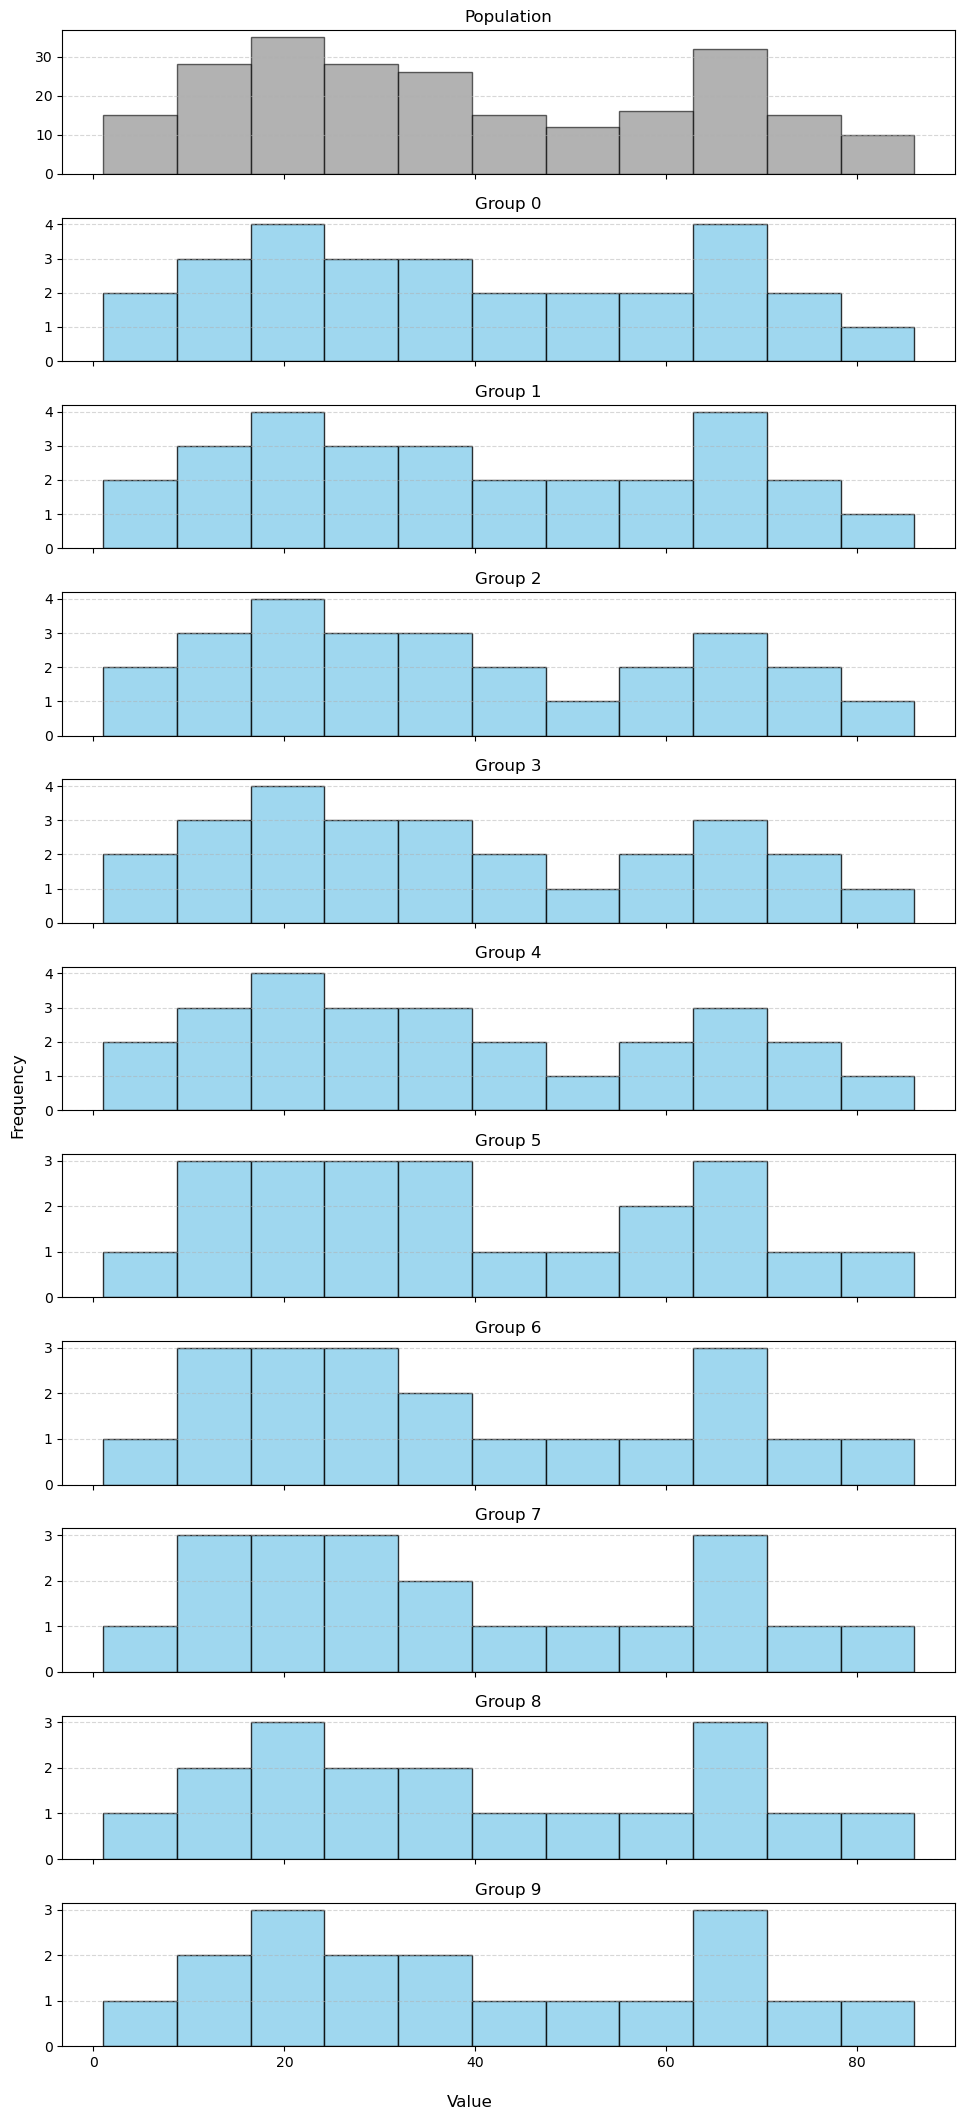

In [155]:
import matplotlib.pyplot as plt
import numpy as np

# 모집단 히스토그램 그릴 때 사용된 bin_edges 재사용
fig, axes = plt.subplots(
    nrows=len(np.unique(groups)) + 1,  # 모집단 + 그룹 수
    ncols=1,
    figsize=(10, 2 * (len(np.unique(groups)) + 1)),  # 전체 높이 자동 조절
    sharex=True,  # x축 공유
)

# 1️⃣ 모집단
axes[0].hist(x, bins=bin_edges, color='gray', edgecolor='black', alpha=0.6)
axes[0].set_title("Population", fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# 2️⃣ 그룹별 히스토그램
for i, g in enumerate(np.unique(groups), start=1):
    axes[i].hist(x[groups == g], bins=bin_edges, color='skyblue', edgecolor='black', alpha=0.8)
    axes[i].set_title(f"Group {g}", fontsize=12)
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

# 공통 x/y 라벨 설정
fig.text(0.5, 0.04, 'Value', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()

In [156]:
for group in range(10):
    point = x[groups == group]
    print(f"Group {group}: n={len(point)}, mean={np.mean(point):.2f}, std={np.std(point, ddof=1):.2f}")

Group 0: n=28, mean=39.71, std=23.40
Group 1: n=28, mean=39.89, std=23.39
Group 2: n=26, mean=38.38, std=23.51
Group 3: n=26, mean=38.73, std=23.53
Group 4: n=26, mean=39.19, std=23.59
Group 5: n=22, mean=39.36, std=23.13
Group 6: n=20, mean=38.65, std=23.92
Group 7: n=20, mean=39.05, std=23.88
Group 8: n=18, mean=41.17, std=24.48
Group 9: n=18, mean=41.56, std=24.88


In [5]:
# 모의 데이터 생성
import numpy as np
from scipy.stats import beta, norm

# 1) [0, 100] 범위의 비정규 혼합 분포 생성
def make_mixture_0_100(n=200, seed=42, mix_ratio=0.65):
    rng = np.random.default_rng(seed)
    n1 = int(n * mix_ratio)
    n2 = n - n1
    comp1 = beta(a=2.0, b=5.0).rvs(size=n1, random_state=seed) * 100.0
    comp2 = np.clip(norm(loc=70.0, scale=8.0).rvs(size=n2, random_state=seed+1), 0.0, 100.0)
    X = np.concatenate([comp1, comp2])
    rng.shuffle(X)
    return np.round(X).astype(int)
# 실행
x = make_mixture_0_100(n=167, seed=234, mix_ratio=0.72)

In [6]:
# 2) 적절한 bin value 찾기
# 적절한 bin value 범위를 하나씩 돌면서 각 bin별 최소 빈도수가 k 이상인 경우 찾기
sorted_x = np.sort(np.asarray(x))
n = len(sorted_x)
k = 8

max_bin = None
if max_bin is None:
    max_bin = n // 2

bin_value = 2 # 시작 bin value
for value in range(bin_value, max_bin + 1):
    print(f"Trying bin_value={value}")
    count, edges = np.histogram(sorted_x, bins=value)
    print(count)
    print(count[count < k].size)
    if count[count < k].size >= 1:
        print(f"Found suitable bin_value: {value-1}")
        adaptive_bin_value = value - 1
        break

Trying bin_value=2
[99 68]
0
Trying bin_value=3
[65 57 45]
0
Trying bin_value=4
[53 46 32 36]
0
Trying bin_value=5
[37 44 31 32 23]
0
Trying bin_value=6
[33 32 34 23 32 13]
0
Trying bin_value=7
[29 29 34 16 20 27 12]
0
Trying bin_value=8
[23 30 22 24 16 16 28  8]
0
Trying bin_value=9
[20 23 22 28 12 17 19 19  7]
1
Found suitable bin_value: 8


In [ ]:
bin_edges = np.histogram_bin_edges(x, bins=adaptive_bin_value)
print(bin_edges)

bin_idx = np.digitize(x, bin_edges, right=False) - 1  # bin index (0~bins-1)
bin_idx[x >= bin_edges[-1]] = len(bin_edges) - 2
print(np.unique(bin_idx, return_counts=True)) # 각 bin별 데이터 수

# 전체 데이터 정렬해서 원본 인덱스
origin_index = np.argsort(x)
print(origin_index)
groups = np.empty(len(x), dtype=int)

current_group = 0
for b in range(adaptive_bin_value):
    print(b) # x와 bin_idx의 인덱스는 동일
    indices_in_bin = np.where(bin_idx == b)[0] # bin에 속하는 데이터의 오리진 인덱스
    print(indices_in_bin)

    sorted_idx_within_bin = indices_in_bin[np.argsort(x[indices_in_bin])]
    # x[indices_in_bin] bin에 속하는 데이터 값 뽑고
    # np.argsort()로 정렬된 인덱스 뽑고, 여기서 오리진 인덱스와 틀어짐
    # indices_in_bin[정렬된 인덱스]로 원본 인덱스 매핑
    print(sorted_idx_within_bin)

    for idx in sorted_idx_within_bin:
        groups[idx] = current_group
        current_group = (current_group + 1) % k  # bin 넘겨도 계속 이어감
    print(groups)
groups

[ 3.    13.625 24.25  34.875 45.5   56.125 66.75  77.375 88.   ]
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([23, 30, 22, 24, 16, 16, 28,  8]))
[ 70   6  25 130  85  56  76 106 165 137  50  74 129 166   1  71  89  13
  20 104  14  37 113  35  66 127  31 157  43  98 118  92 133  23  59 164
  11  97 124 148  57  15  28  79  16   3  73  84  10 140 149  90  58 125
  65  52   9 134  38  72   5  24  27  67  22  33  64 121  41  17 151 152
  30   2 102 126  75 147  83  69  12 122  36 159  19  61 150  99  55 139
 154 115  42 103  63  53 117  39 162 119 101  51 145   4  29 109 114 143
  62 144  40 153 123   0  48  26 111  95 105  68  78  88  47  94 131 161
  82 128   8 110  80  21  60 135 112 120  77 116 158  18 146   7  86  93
  46  49  91 155  34 136  96  54 156  44 160  32 108 100 132  87  45  81
 107 163 138 142 141]
0
asdfsadfa [  1   6  13  14  20  25  37  50  56  70  71  74  76  85  89 104 106 113
 129 130 137 165 166]
werqwer [ 70   6  25 130  85 137 106  50  56 165  76  74 129  89   1  13  

array([0, 6, 6, 3, 6, 3, 1, 5, 0, 0, 0, 4, 5, 7, 6, 6, 5, 4, 0, 3, 3, 3,
       7, 1, 5, 2, 3, 0, 5, 0, 0, 3, 4, 1, 3, 0, 5, 4, 2, 1, 4, 3, 4, 1,
       7, 0, 2, 2, 1, 1, 7, 4, 6, 6, 5, 7, 0, 1, 3, 2, 7, 1, 5, 7, 2, 7,
       7, 6, 7, 7, 0, 0, 4, 2, 3, 4, 2, 4, 0, 4, 1, 1, 4, 0, 6, 4, 7, 7,
       1, 5, 4, 0, 7, 6, 3, 4, 6, 2, 5, 1, 5, 5, 1, 5, 2, 5, 6, 2, 3, 1,
       2, 6, 6, 5, 2, 3, 2, 0, 6, 3, 5, 5, 6, 2, 7, 5, 3, 4, 5, 4, 3, 6,
       6, 0, 1, 4, 0, 5, 4, 2, 7, 6, 5, 3, 6, 7, 1, 6, 0, 1, 2, 7, 2, 7,
       0, 4, 1, 2, 3, 4, 2, 7, 2, 3, 3, 1, 1])

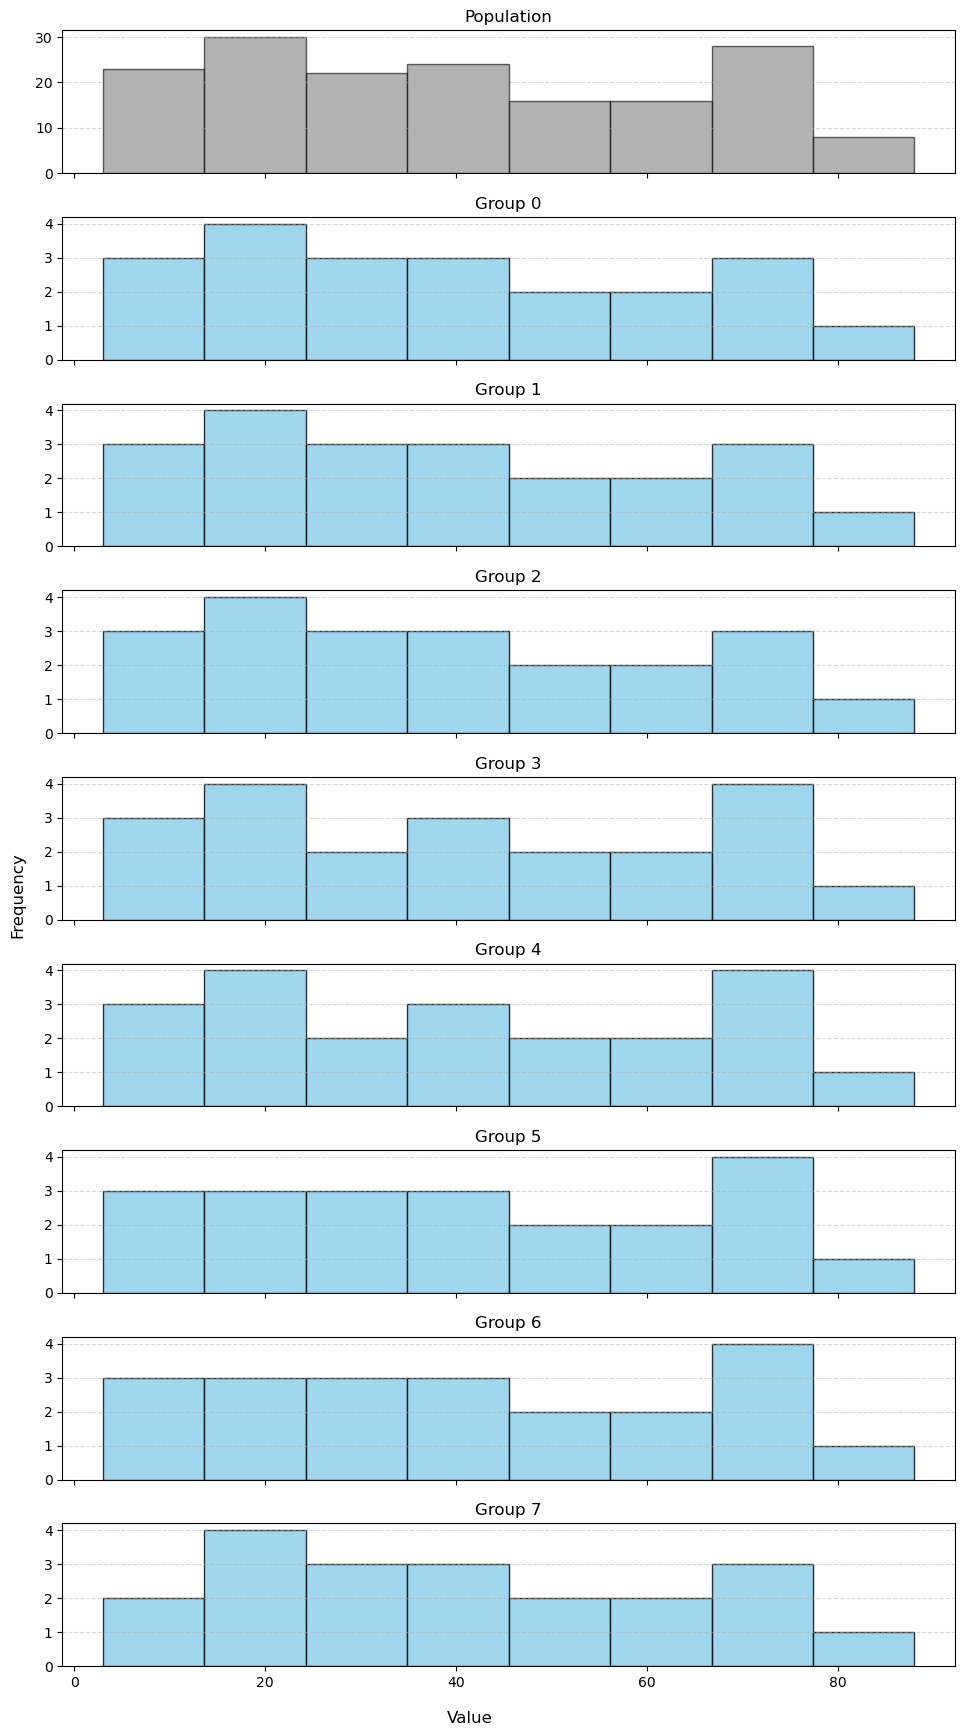

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# 모집단 히스토그램 그릴 때 사용된 bin_edges 재사용
fig, axes = plt.subplots(
    nrows=len(np.unique(groups)) + 1,  # 모집단 + 그룹 수
    ncols=1,
    figsize=(10, 2 * (len(np.unique(groups)) + 1)),  # 전체 높이 자동 조절
    sharex=True,  # x축 공유
)

# 1️⃣ 모집단
axes[0].hist(x, bins=bin_edges, color='gray', edgecolor='black', alpha=0.6)
axes[0].set_title("Population", fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# 2️⃣ 그룹별 히스토그램
for i, g in enumerate(np.unique(groups), start=1):
    axes[i].hist(x[groups == g], bins=bin_edges, color='skyblue', edgecolor='black', alpha=0.8)
    axes[i].set_title(f"Group {g}", fontsize=12)
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

# 공통 x/y 라벨 설정
fig.text(0.5, 0.04, 'Value', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()

In [53]:
for group in range(k):
    point = x[groups == group]
    print(f"Group {group}: n={len(point)}, mean={np.mean(point):.2f}, std={np.std(point, ddof=1):.2f}")

Group 0: n=21, mean=39.33, std=23.50
Group 1: n=21, mean=39.90, std=23.37
Group 2: n=21, mean=40.24, std=23.57
Group 3: n=21, mean=41.10, std=23.53
Group 4: n=21, mean=41.57, std=23.83
Group 5: n=21, mean=42.14, std=23.79
Group 6: n=21, mean=42.52, std=23.87
Group 7: n=20, mean=40.50, std=22.12


In [ ]:
# serpentine 버전 코드

In [165]:
bin_edges = np.histogram_bin_edges(x, bins=11)
print(bin_edges)

bin_idx = np.digitize(x, bin_edges, right=False) - 1  # bin index (0~bins-1)
bin_idx[x >= bin_edges[-1]] = len(bin_edges) - 2
print(np.unique(bin_idx, return_counts=True)) # 각 bin별 데이터 수

# 전체 데이터 정렬해서 원본 인덱스
origin_index = np.argsort(x)
print(origin_index)
groups = np.empty(len(x), dtype=int)

group = 0          # 현재 그룹
direction = 1      # 1이면 정방향, -1이면 역방향

for b in range(11):
    print(b)
    indices_in_bin = np.where(bin_idx == b)[0] # bin 0에 속하는 데이터의 오리진 인덱스
    if len(indices_in_bin) == 0:
            continue

    # bin 내부 정렬
    sorted_idx_within_bin = indices_in_bin[np.argsort(x[indices_in_bin])]

    # bin 내부에서 하나씩 배정
    for idx in sorted_idx_within_bin:
        groups[idx] = group

        # 방향에 따라 다음 그룹 번호 계산
        group += direction

        # 끝에 닿으면 방향 전환
        if group == 9:
            direction = -1  # 뒤집기
        elif group == 0:
            direction = 1   # 다시 앞으로
groups

[ 1.          8.72727273 16.45454545 24.18181818 31.90909091 39.63636364
 47.36363636 55.09090909 62.81818182 70.54545455 78.27272727 86.        ]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([15, 28, 35, 28, 26, 15, 12, 16, 32, 15, 10]))
[134   0  94 229 128 119  31  29  34 142  52 151 178 140 211  78  68  96
  15  93 125 153 137 192  37 145 146 109 221  27 209 111  50 133 190  17
 197 185  53  59 101  61 225  57  33 223  41  65  79 227 179  38 203 105
  92 139  88   3  14 180  43 136 177 212 208 230  45  85  64  66 188 219
 201 156 226  71 161 172 162 149 159 218 110 135 173 170 164 115   1   4
 222   2 174 169 121 198   5  62  95  82 182 207 141 163 220  40  48  46
 181  35  76 160 152 129  21 210 184  98 171  91   9 202 196 213  51 187
  12  69 204 217  75 167  81  80   8  54 123 199 157  19  70  67 205 122
 112  89  83 131 120 100 158  97  22 186  44  73  10  30  26 117  13  23
 189 103  72  20 132 175  55  36 138  47 228 114  77 224 216 183 195 176
  87 206  49 148

array([1, 3, 0, 2, 2, 6, 1, 6, 6, 5, 6, 2, 3, 3, 4, 0, 7, 0, 3, 5, 3, 3,
       7, 1, 3, 5, 5, 6, 7, 6, 4, 7, 3, 7, 8, 2, 6, 5, 3, 6, 3, 8, 6, 8,
       9, 7, 1, 7, 0, 6, 3, 1, 8, 4, 7, 8, 1, 8, 0, 3, 8, 2, 7, 6, 8, 6,
       9, 4, 3, 1, 3, 4, 1, 7, 9, 0, 4, 7, 2, 4, 8, 9, 5, 2, 5, 4, 8, 0,
       0, 1, 8, 3, 1, 2, 2, 8, 1, 8, 9, 0, 4, 5, 7, 2, 7, 3, 4, 1, 5, 9,
       8, 7, 0, 3, 6, 2, 1, 2, 2, 4, 5, 1, 1, 8, 7, 1, 8, 5, 5, 2, 4, 3,
       4, 4, 0, 4, 7, 6, 9, 1, 7, 4, 9, 9, 9, 8, 7, 3, 2, 6, 8, 6, 5, 4,
       4, 7, 1, 6, 6, 9, 6, 2, 7, 6, 5, 4, 5, 5, 2, 3, 6, 8, 3, 7, 1, 5,
       1, 6, 5, 5, 5, 1, 7, 2, 8, 1, 8, 2, 2, 0, 2, 4, 3, 6, 8, 3, 6, 1,
       8, 7, 4, 1, 7, 2, 2, 2, 1, 9, 6, 5, 7, 4, 5, 4, 5, 2, 4, 4, 8, 0,
       5, 8, 4, 9, 5, 6, 5, 7, 8, 3, 3, 3])

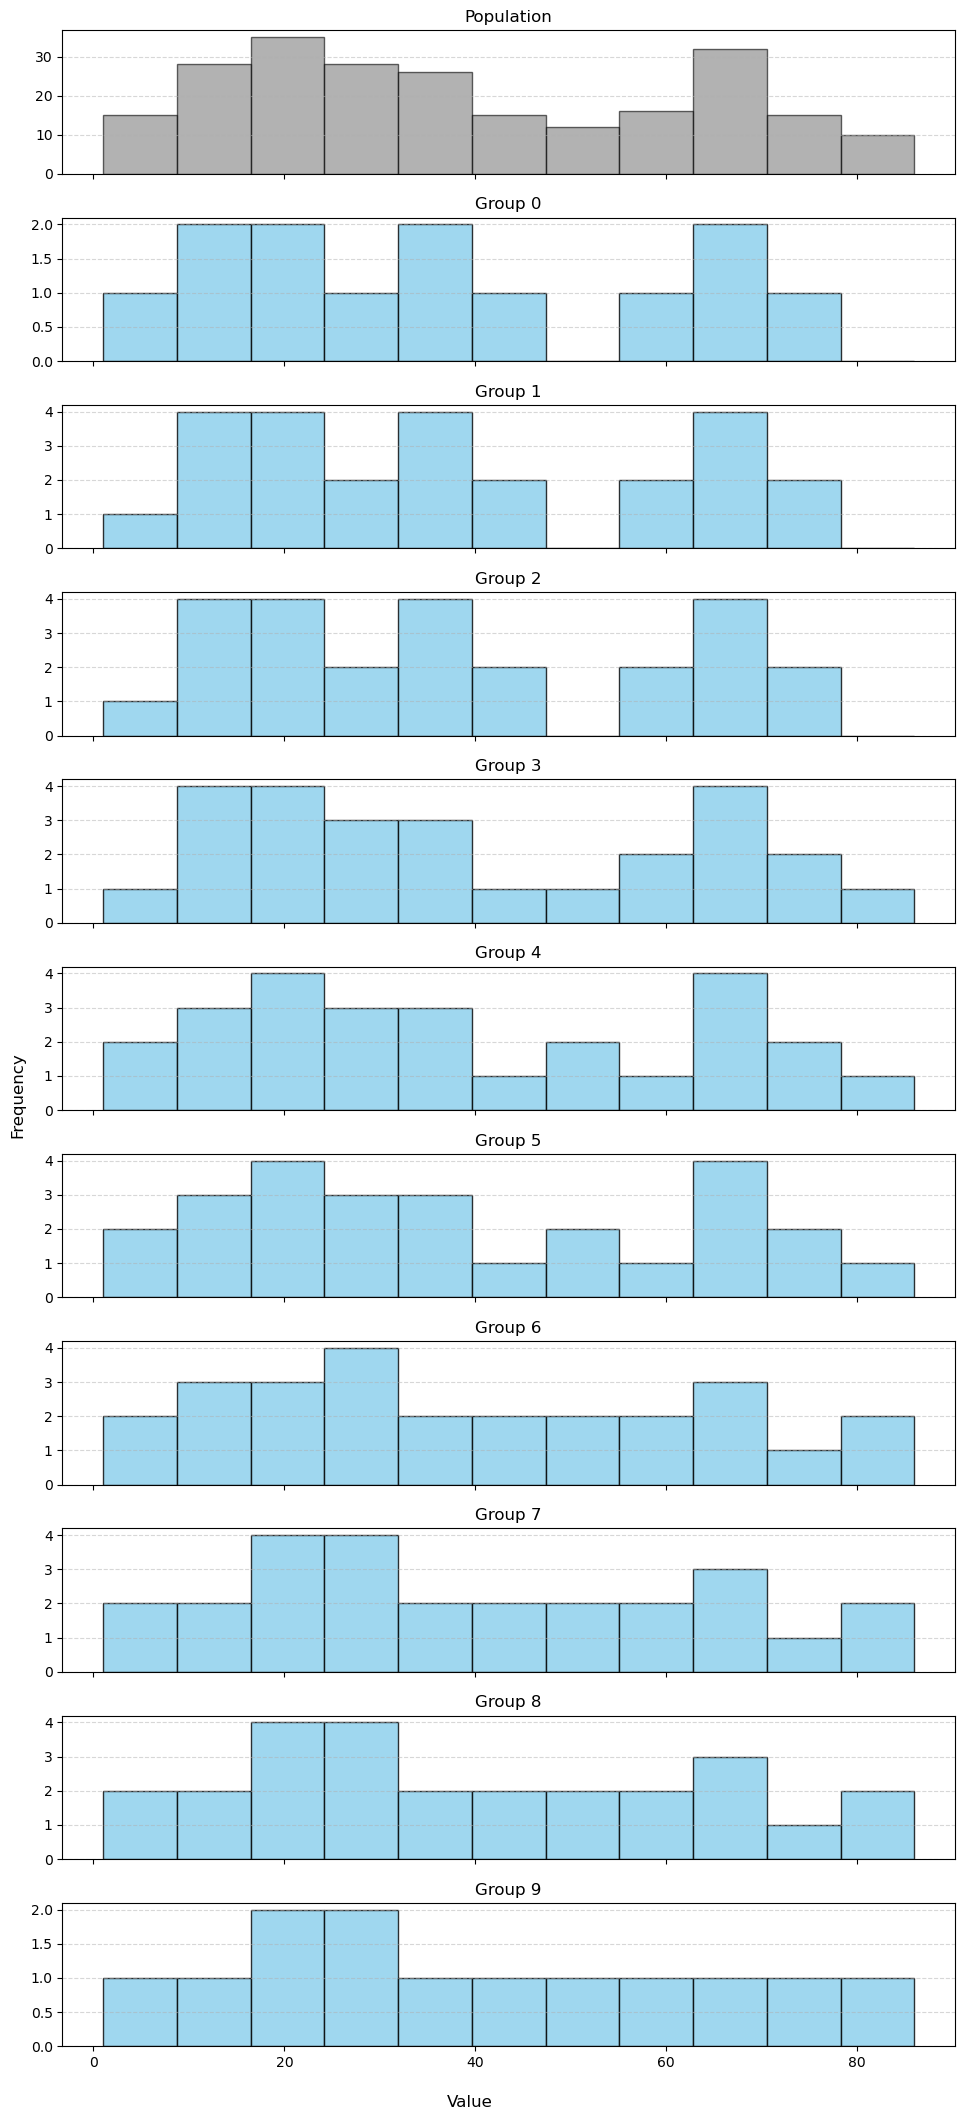

In [166]:
import matplotlib.pyplot as plt
import numpy as np

# 모집단 히스토그램 그릴 때 사용된 bin_edges 재사용
fig, axes = plt.subplots(
    nrows=len(np.unique(groups)) + 1,  # 모집단 + 그룹 수
    ncols=1,
    figsize=(10, 2 * (len(np.unique(groups)) + 1)),  # 전체 높이 자동 조절
    sharex=True,  # x축 공유
)

# 1️⃣ 모집단
axes[0].hist(x, bins=bin_edges, color='gray', edgecolor='black', alpha=0.6)
axes[0].set_title("Population", fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# 2️⃣ 그룹별 히스토그램
for i, g in enumerate(np.unique(groups), start=1):
    axes[i].hist(x[groups == g], bins=bin_edges, color='skyblue', edgecolor='black', alpha=0.8)
    axes[i].set_title(f"Group {g}", fontsize=12)
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

# 공통 x/y 라벨 설정
fig.text(0.5, 0.04, 'Value', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()

In [167]:
for group in range(10):
    point = x[groups == group]
    print(f"Group {group}: n={len(point)}, mean={np.mean(point):.2f}, std={np.std(point, ddof=1):.2f}")

Group 0: n=13, mean=36.92, std=23.91
Group 1: n=25, mean=38.44, std=22.76
Group 2: n=25, mean=38.36, std=22.76
Group 3: n=26, mean=40.15, std=24.17
Group 4: n=26, mean=40.00, std=24.04
Group 5: n=26, mean=39.92, std=24.07
Group 6: n=26, mean=40.12, std=24.01
Group 7: n=26, mean=40.08, std=23.77
Group 8: n=26, mean=39.88, std=23.62
Group 9: n=13, mean=39.85, std=24.22


In [ ]:
# 양 끝 그룹은 왕복의 끝점이라 다른 그룹보다 적은 빈도로 등장함
# 그래서 그룹 0과 9의 데이터 수가 상대적으로 적음

In [55]:
x1 = [1,2,3,4,5]
x2 = [4,2,1,2,3]
x = (x1, x2)
x

([1, 2, 3, 4, 5], [4, 2, 1, 2, 3])

In [56]:
len(x)

2